# Turtle Trading

Turtle trading is a project set up by commodity traders Richard Dennis and William Eckhardt in 1983 to prove that anyone can be taught to trade by following simple rules. The project was successful, with many of the traders making consistent returns by following the rules and becoming successful fund managers after the project concluded.

In this notebook, I backtest the results of the turtle trading rules and analyse the reasons for their success.

The turtle trading rules are:
1. Enter a position when prices crosses 20-day high.
2. Exit when prices fall below 10-day low or a trailing stop loss set at 3 x 20-day ATR.

There are other rules with regards to position sizing, risk management, pyramiding (adding to trades), etc. However, I ignored these since I want to see primarily how the entry and exit rules perform. In a similar vein, the commission fees, bid-ask spread, and other frictional costs are neglected.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from utils import misc
import datetime as dt
from trade_obj import *
from simple_backtester import backTester

# Use SPDR Gold Trust $GLD for backtesting to represent commodity trading
ticker = 'GLD'
df = pd.read_csv('datasets/stock_price_series/' + ticker + '.csv')
df = misc.clean_df(df)
df = df.set_index('date')

Generate indicators for entry and exit

In [22]:
df['20_up_bound'] = df['high'].shift(1).rolling(20).max()
df['20_low_bound'] = df['low'].shift(1).rolling(20).min()
df['10_up_bound'] = df['high'].shift(1).rolling(10).max()
df['10_low_bound'] = df['low'].shift(1).rolling(10).min()

df['High-Low'] = df['high'] - df['low']
df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
df['ATR'] = df['TR'].rolling(20).mean()

df = df.dropna()
# df = df[-1000:]

Run backtest in simple customer framework

In [23]:
bt = backTester()
bt.set_asset(df)

# convert to np array to save time
upbound20 = df['20_up_bound'].to_numpy()
lowbound20 = df['20_low_bound'].to_numpy()
upbound10 = df['10_up_bound'].to_numpy()
lowbound10 = df['10_low_bound'].to_numpy()
atr = df['ATR'].to_numpy()

stop_loss_arr = []
stop_loss = np.nan

tl = tradeList()
last_trade_win = False
open_trade = None



for i in range(len(bt.df)):
    
    order_quantity = 0
    order_price = 0
    n = atr[i]
    

    # no open trades
    if open_trade == None:
        # breakout from 20 day high
        if bt.high[i] > upbound20[i]:

            long_entry_price = upbound20[i]
            # calculate stop_loss
            stop_loss = long_entry_price - 3 * n
                            
            # order price at breakout
            order_price = max(long_entry_price, bt.low[i])
            # order 1 unit
            order_quantity = bt.cash // long_entry_price
            
            # open trade on record
            open_trade = trade(bt.date[i], order_price, order_quantity, type='long20')
          

    # open trades present 
    else:
        # if open trades are long
        if open_trade.quantity > 0:
            pass
            # calculate trailing stop_loss
            stop_loss = max(stop_loss, bt.high[i] - 3 * n)
            # combine low bound 10 and trailing stop loss
            stop_loss = max(stop_loss, lowbound10[i])
            
            # exit trade if stop loss is triggered
            if bt.low[i] < stop_loss:

                # print(f'--- index {i}, date: {bt.date[i]} ---')
                # print(f'low: {bt.low[i]} < stop_loss: {stop_loss}')
                # exit price at stoploss
                order_price = min(stop_loss, bt.high[i])
                order_quantity = -open_trade.quantity
                    
                open_trade.close(bt.date[i], order_price)
                tl.append(open_trade)
                
                open_trade = None
                stop_loss = np.nan
    
        
    stop_loss_arr.append(stop_loss)

    bt.take_action(order_quantity=order_quantity, order_price=order_price)
            
# record stoplosses and entry prices for plotting
df['stop_loss'] = stop_loss_arr
df['entry_price'] = np.nan
df['exit_price'] = np.nan
df['entry_price'] = np.nan
df['exit_price'] = np.nan

for t in tl.list:
    for i in range(len(t.entry_date)):
        df.loc[df.index == t.entry_date[i], 'entry_price'] = t.entry_price[i]
        
    df.loc[df.index == t.exit_date, 'exit_price'] = t.exit_price



end


### Portfolio Stats

This section looks at the stats of a portfolio that runs this trade at no leverage.

This portfolio has lower returns and lower volatility/drawdowns compared to a buy-hold strategy. The portfolio manages to avoid the large drawdown events, thus preserving capital.

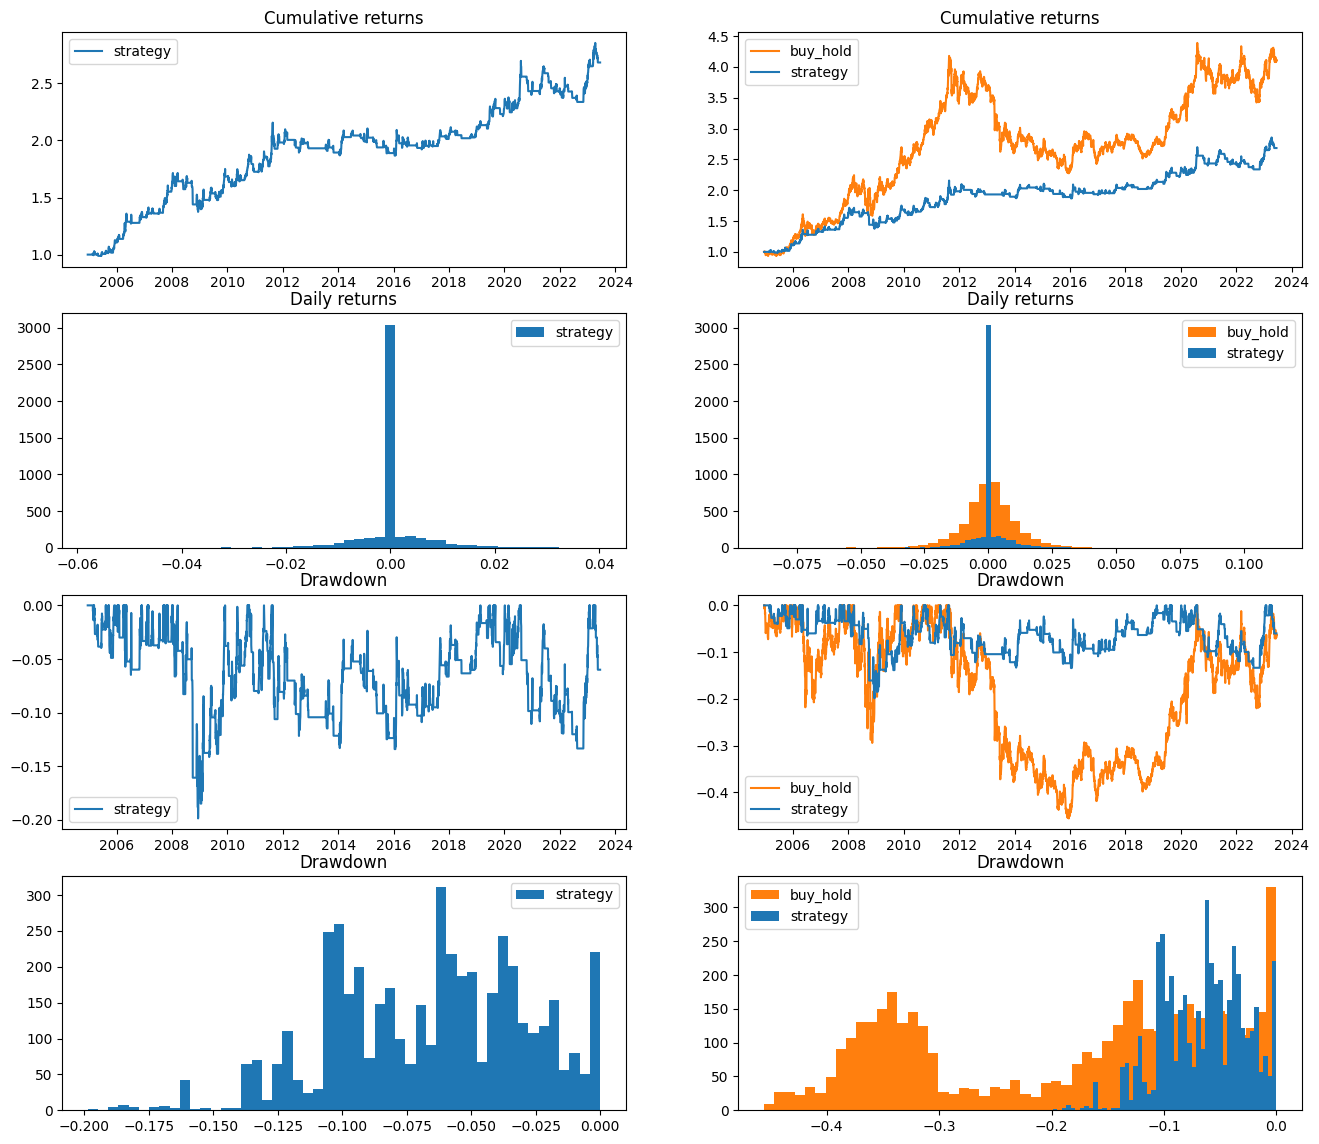

In [24]:
bt.analyse()
bt.plot_graphs()

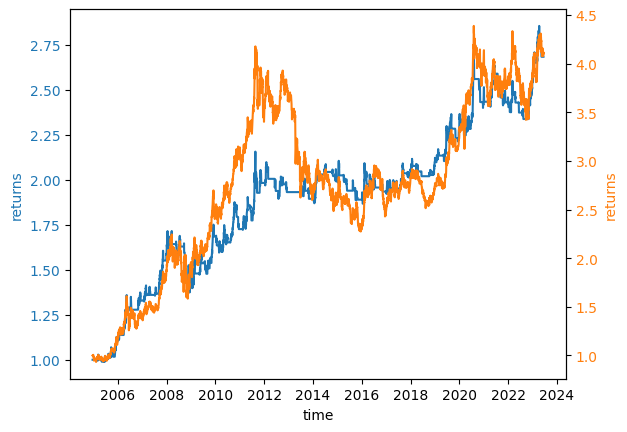

In [25]:
fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('returns', color=color)
ax1.plot(bt.date, bt.records['cum_returns'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'C1'
ax2 = ax1.twinx()
ax2.set_ylabel('returns', color=color)
ax2.plot(bt.date, bt.records['buy_hold_cum_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_facecolor('xkcd:white')
plt.show()

In [26]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print('---------')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print('---------')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

Annualised return:          0.05482393669985086
buy_hold annual return:     0.07942445978816837
---------
Annualised vol:             0.10107389019402316
buy_hold annual vol:        0.17799809335671715
---------
Sharpe ratio:               0.5424144316065197
buy_hold Sharpe ratio:      0.44620960983552643


### Trade record stats

This section looks at the backtest results on a trade-by-trade basis.

In [27]:
tl.analyse(bt.df)
tl.stats

{'num_wins': 61,
 'num_loss': 54,
 'win_rate': 0.5304347826086957,
 'profit_total': 1683457.4034666063,
 'profit_mean': 14638.760030144402,
 'returns_mean': 0.00939782702734891,
 'returns_std': 0.040366973628685986,
 'time_in_trade_mean': 21.321739130434782,
 'time_in_trade_std': 15.306544768116927,
 'capital_at_risk_mean': 1876656.8172666135,
 'win_returns_mean': 0.03727128382070503,
 'win_returns_std': 0.03497426317251286,
 'win_profit_mean': 66159.21153714227,
 'win_time_in_trade_mean': 30.114754098360656,
 'win_time_in_trade_std': 15.466197939006362,
 'loss_returns_mean': -0.022088855646627423,
 'loss_returns_std': 0.01469263550688972,
 'loss_profit_mean': -43560.2685240569,
 'loss_time_in_trade_mean': 11.38888888888889,
 'loss_time_in_trade_std': 6.605934058093089}

We plot every single trade to view the characteristics of each trade.

trade 0
entry: [43.20000076293945]
cost_basis: 43.20000076293945
exit: 43.25
returns: 0.0011573897263316803
20


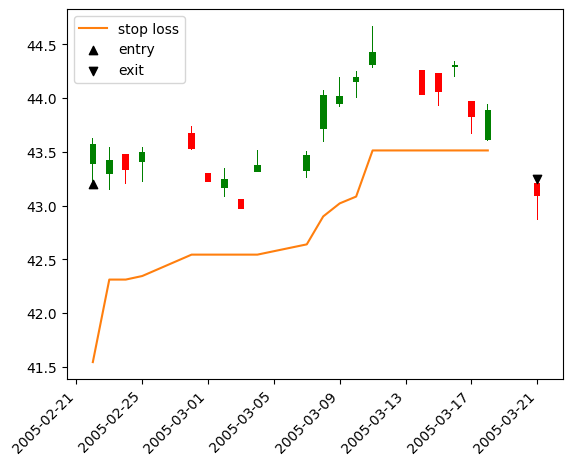

trade 1
entry: [43.25]
cost_basis: 43.25
exit: 42.73099975585937
returns: -0.012000005644870007
11


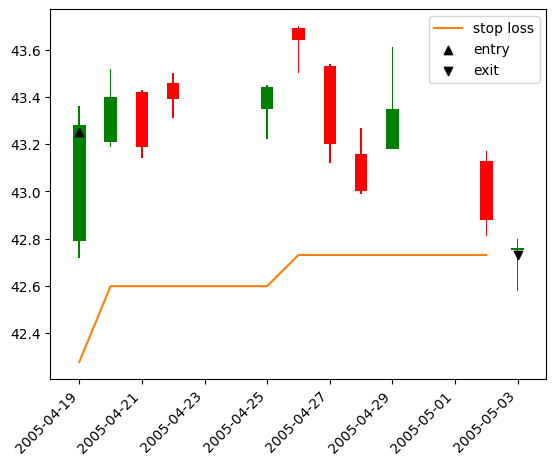

trade 2
entry: [42.650001525878906]
cost_basis: 42.650001525878906
exit: 43.36000061035156
returns: 0.016647105722653897
16


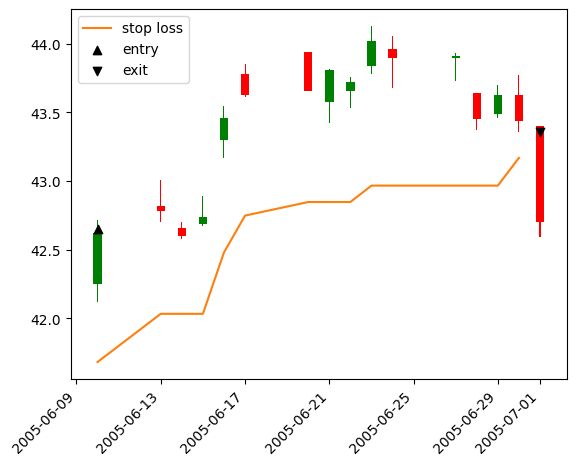

trade 3
entry: [43.34999847412109]
cost_basis: 43.34999847412109
exit: 43.803502845764164
returns: 0.010461462228512165
11


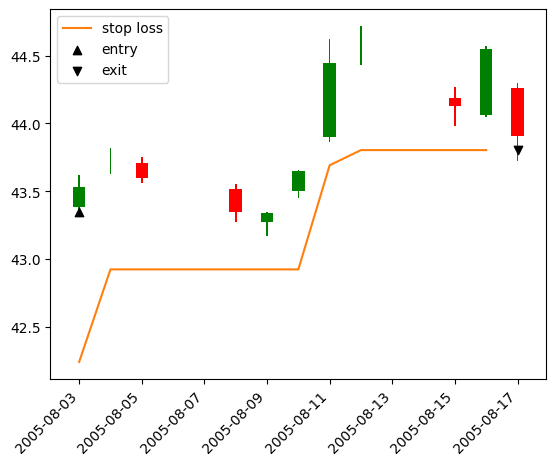

trade 4
entry: [44.720001220703125]
cost_basis: 44.720001220703125
exit: 45.71550045013427
returns: 0.022260715613985276
14


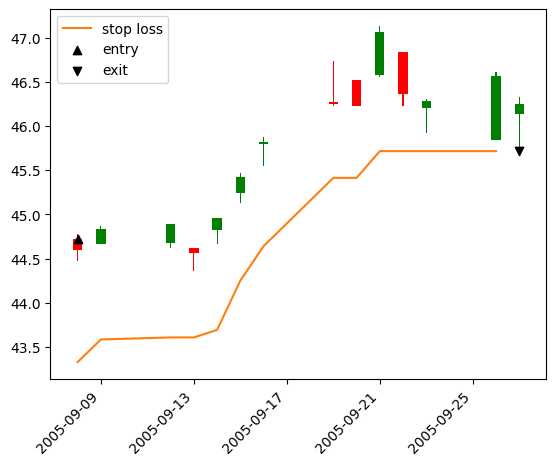

trade 5
entry: [47.130001068115234]
cost_basis: 47.130001068115234
exit: 46.13999938964844
returns: -0.021005763972633575
15


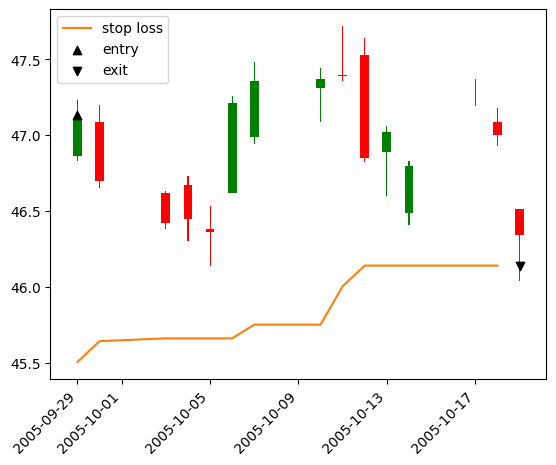

trade 6
entry: [47.41999816894531]
cost_basis: 47.41999816894531
exit: 51.595496559143065
returns: 0.08805353334940083
19


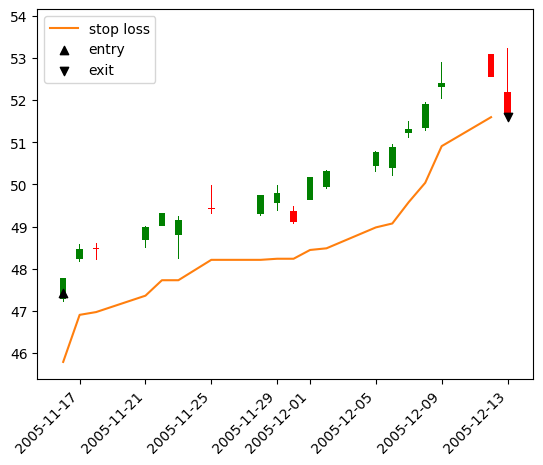

trade 7
entry: [53.7599983215332]
cost_basis: 53.7599983215332
exit: 55.27000045776367
returns: 0.028087838232421367
22


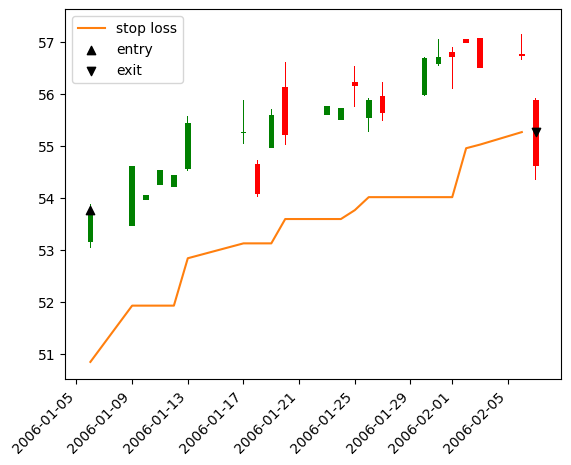

trade 8
entry: [56.81999969482422]
cost_basis: 56.81999969482422
exit: 61.04750099182129
returns: 0.07440164237421062
16


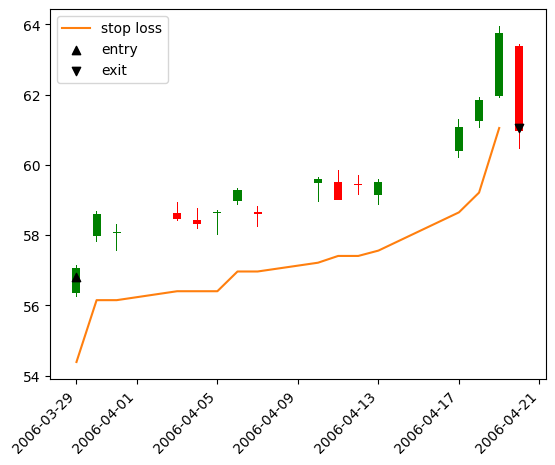

trade 9
entry: [63.95000076293945]
cost_basis: 63.95000076293945
exit: 67.39950122833253
returns: 0.05394058521094091
13


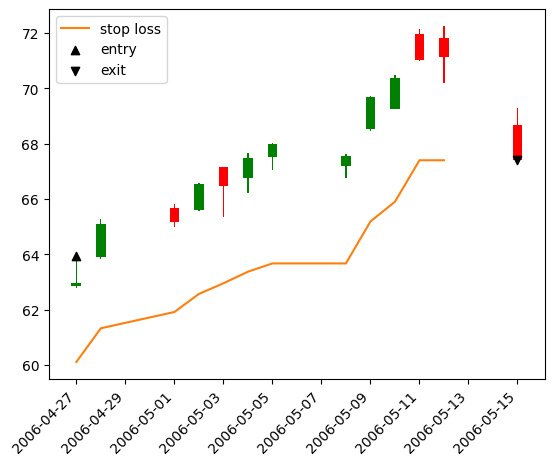

trade 10
entry: [62.84999847412109]
cost_basis: 62.84999847412108
exit: 62.34449844360351
returns: -0.008042960108037392
9


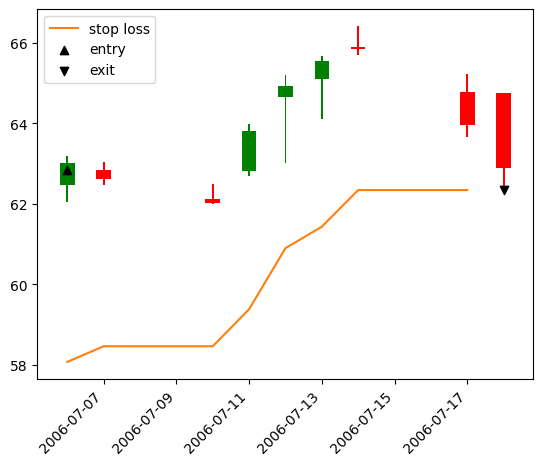

trade 11
entry: [59.880001068115234]
cost_basis: 59.880001068115234
exit: 62.25
returns: 0.039579139773040804
28


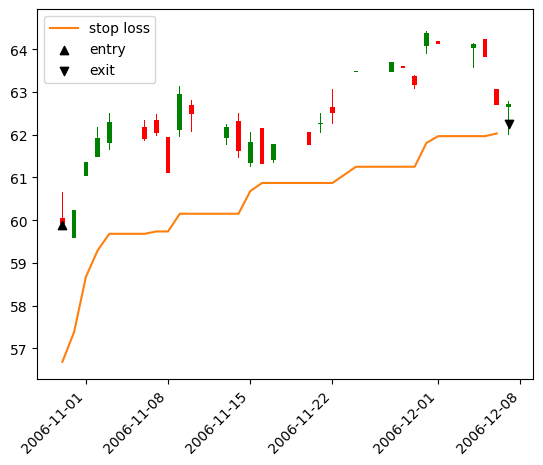

trade 12
entry: [64.0199966430664]
cost_basis: 64.0199966430664
exit: 65.54050006866456
returns: 0.023750445256588842
25


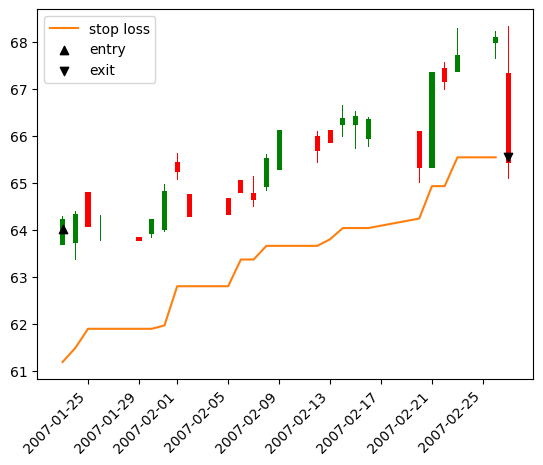

trade 13
entry: [66.4800033569336]
cost_basis: 66.4800033569336
exit: 66.5
returns: 0.00030079184802448843
20


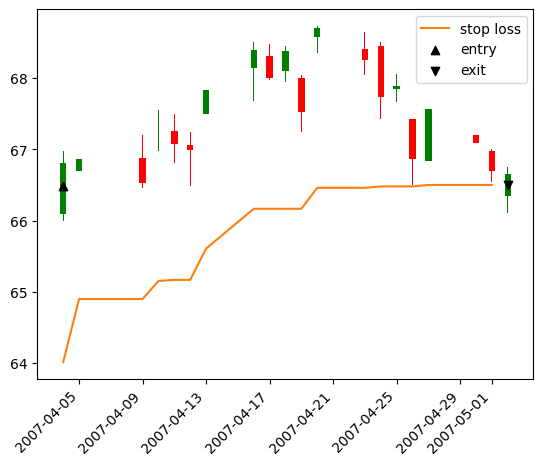

trade 14
entry: [65.55999755859375]
cost_basis: 65.55999755859375
exit: 65.89549732208252
returns: 0.005117446247445619
14


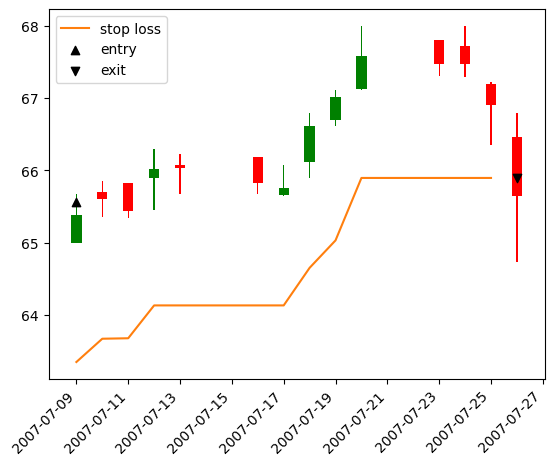

trade 15
entry: [67.54000091552734]
cost_basis: 67.54000091552734
exit: 71.3499984741211
returns: 0.05641097878217288
23


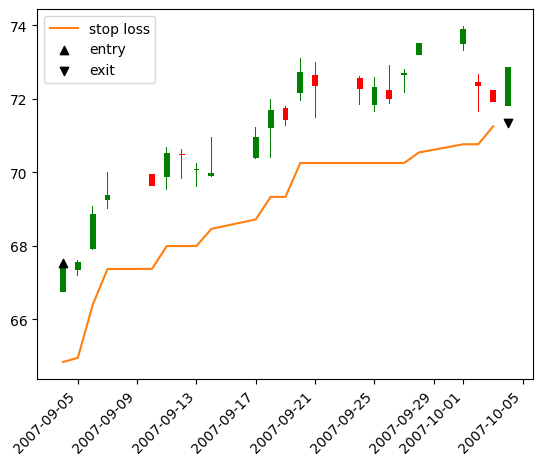

trade 16
entry: [73.9800033569336]
cost_basis: 73.9800033569336
exit: 79.4495002746582
returns: 0.07393209880426421
23


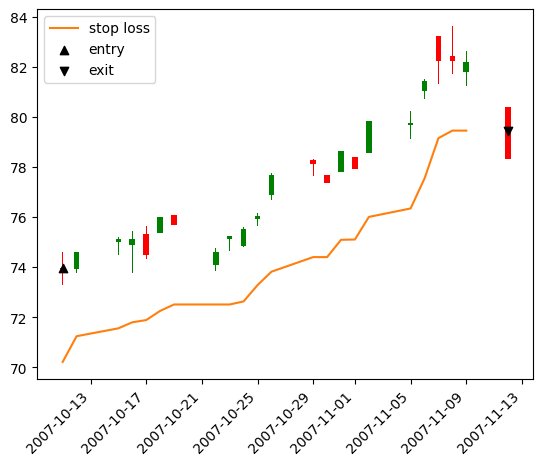

trade 17
entry: [81.0]
cost_basis: 81.0
exit: 86.33450126647949
returns: 0.06585804032690731
15


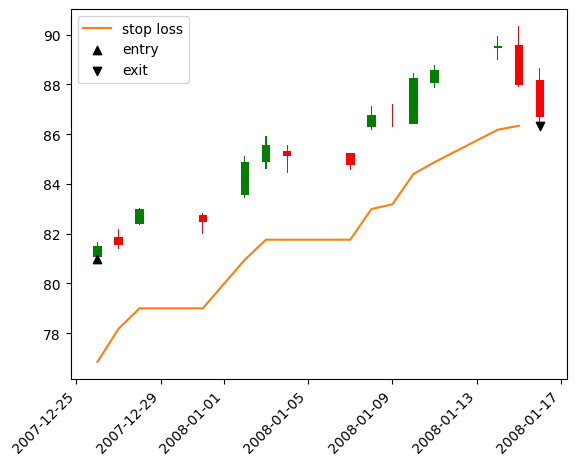

trade 18
entry: [90.3499984741211]
cost_basis: 90.3499984741211
exit: 87.49650077819824
returns: -0.03158270884465129
8


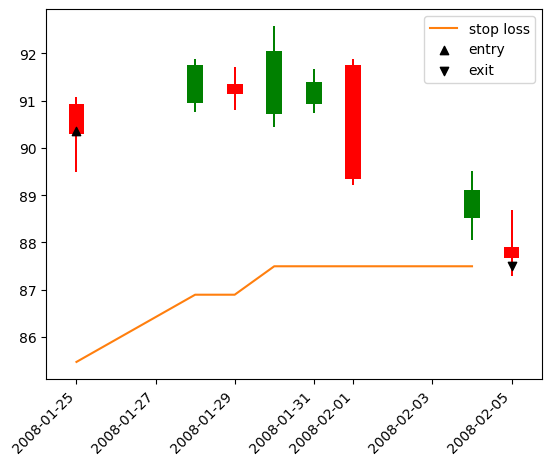

trade 19
entry: [92.58000183105467]
cost_basis: 92.58000183105467
exit: 94.96500244140624
returns: 0.025761509647665107
21


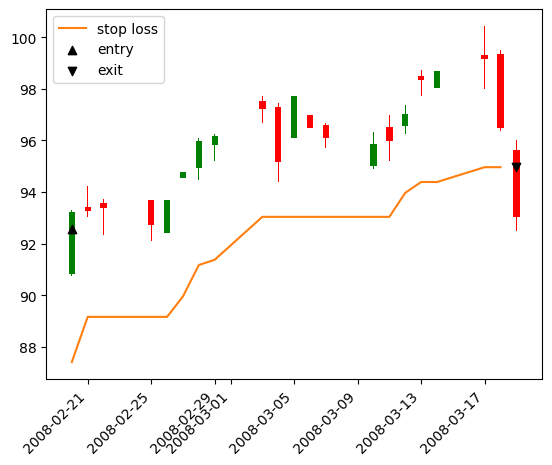

trade 20
entry: [91.16999816894533]
cost_basis: 91.16999816894533
exit: 87.32599830627441
returns: -0.042162991552853524
6


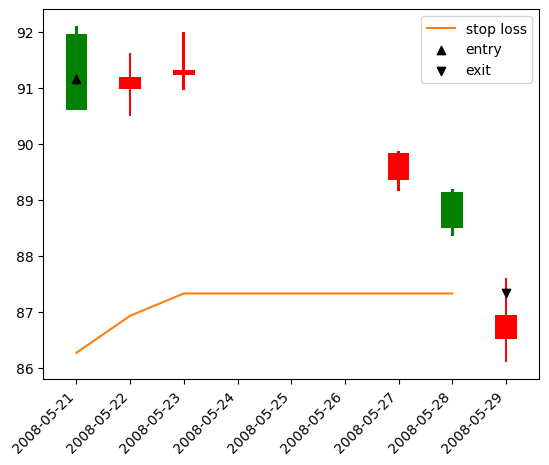

trade 21
entry: [89.61000061035156]
cost_basis: 89.61000061035156
exit: 92.79000091552734
returns: 0.03548711397741509
19


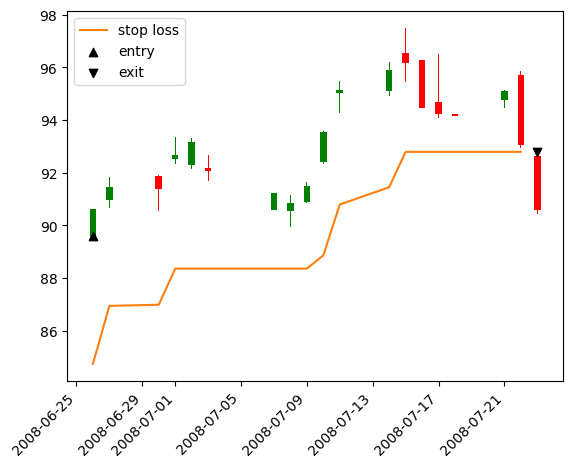

trade 22
entry: [84.54000091552734]
cost_basis: 84.54000091552734
exit: 82.80599937438964
returns: -0.020511018717285338
2


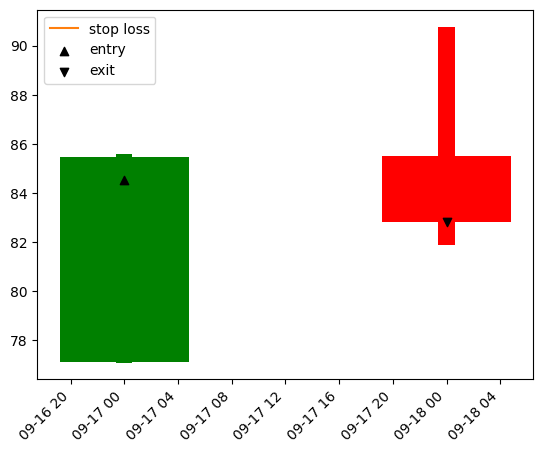

trade 23
entry: [90.77999877929688]
cost_basis: 90.77999877929688
exit: 81.9000015258789
returns: -0.09781887390202439
4


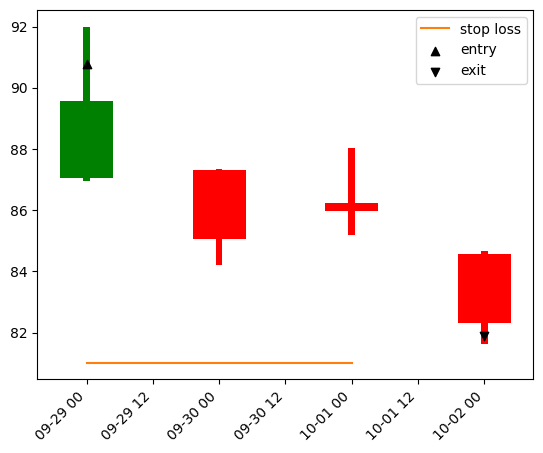

trade 24
entry: [76.36000061035156]
cost_basis: 76.36000061035156
exit: 73.87349586486816
returns: -0.03256292202211329
10


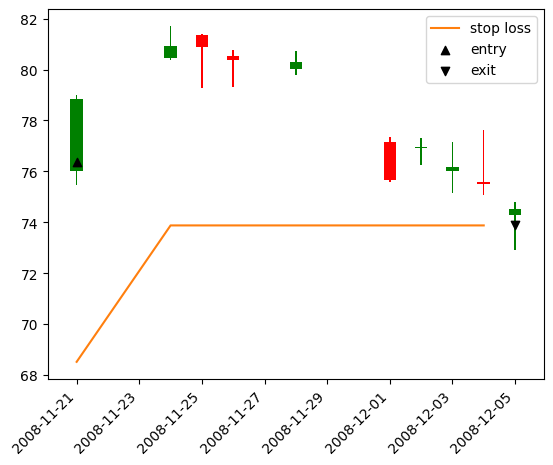

trade 25
entry: [81.72000122070312]
cost_basis: 81.72000122070312
exit: 82.04000091552734
returns: 0.003915806290310594
21


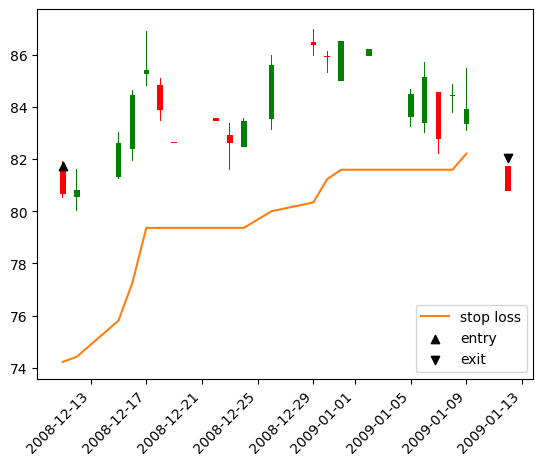

trade 26
entry: [87.0999984741211]
cost_basis: 87.0999984741211
exit: 92.14999809265136
returns: 0.05797933073478418
24


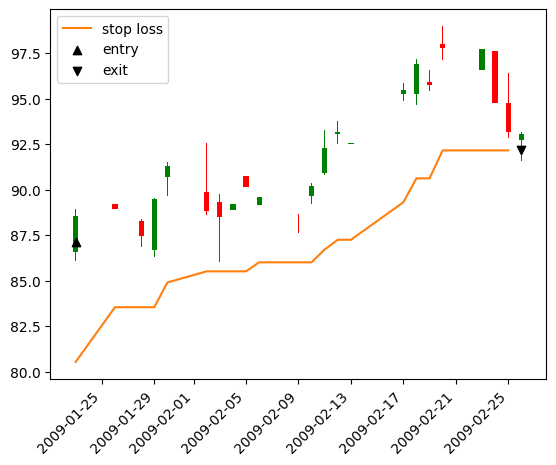

trade 27
entry: [89.83999633789062]
cost_basis: 89.83999633789062
exit: 93.29349861145019
returns: 0.03844058787102852
22


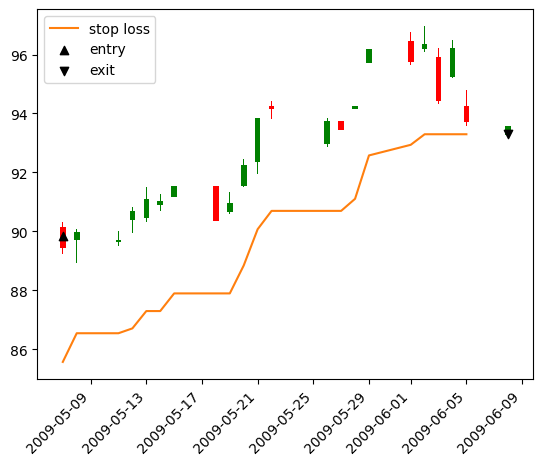

trade 28
entry: [93.0]
cost_basis: 93.0
exit: 91.5500030517578
returns: -0.015591365034862385
8


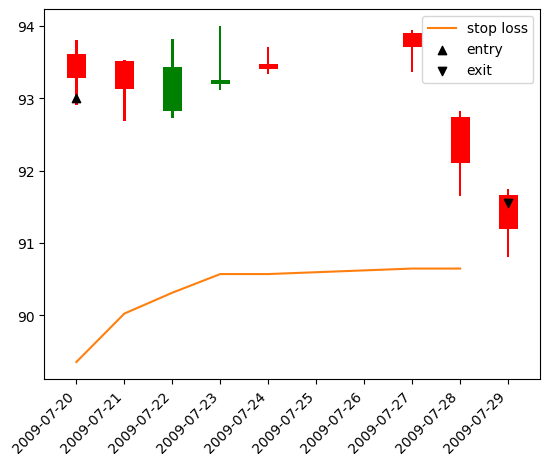

trade 29
entry: [94.0]
cost_basis: 94.0
exit: 91.86000061035156
returns: -0.02276595095370678
12


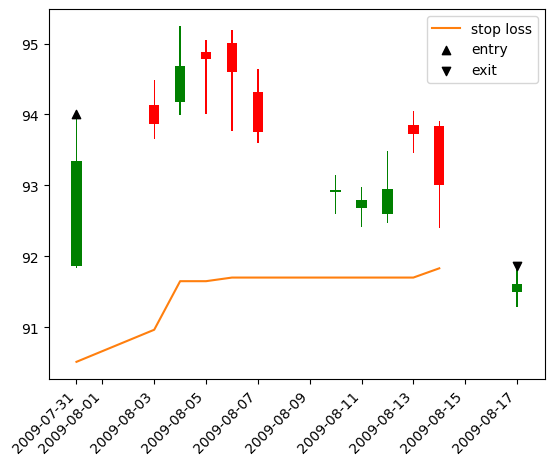

trade 30
entry: [95.19000244140624]
cost_basis: 95.19000244140624
exit: 97.13999938964844
returns: 0.02048531251422662
17


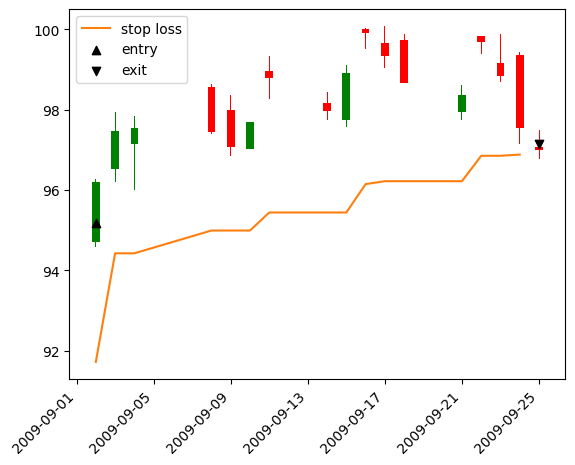

trade 31
entry: [100.54000091552734]
cost_basis: 100.54000091552734
exit: 102.52999877929688
returns: 0.019793095739490858
15


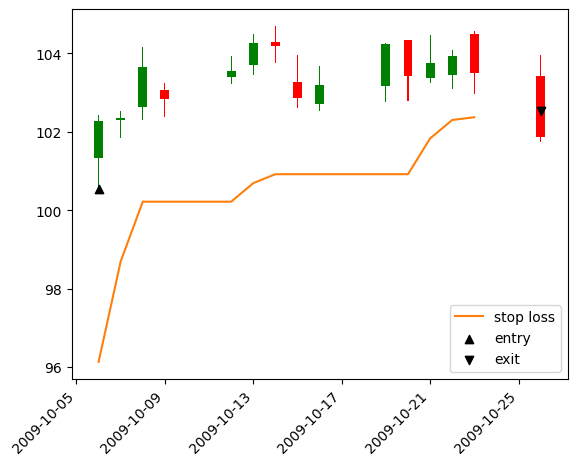

trade 32
entry: [104.6999969482422]
cost_basis: 104.6999969482422
exit: 114.67400169372559
returns: 0.09526270330661014
23


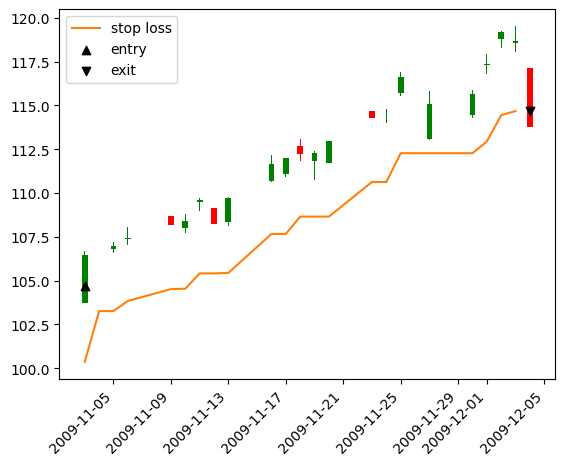

trade 33
entry: [112.5199966430664]
cost_basis: 112.5199966430664
exit: 109.26000213623048
returns: -0.028972579133442478
7


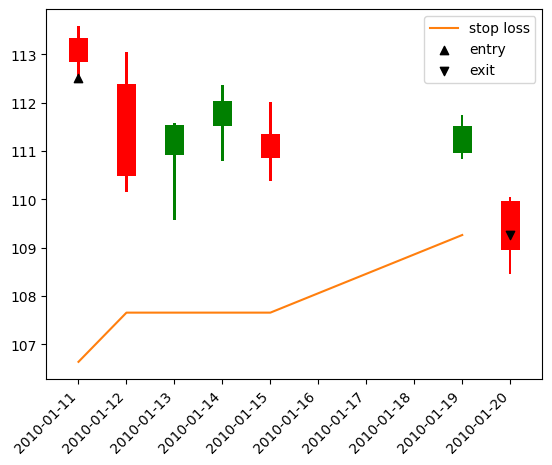

trade 34
entry: [110.0500030517578]
cost_basis: 110.0500030517578
exit: 107.86000061035156
returns: -0.019900067066570205
17


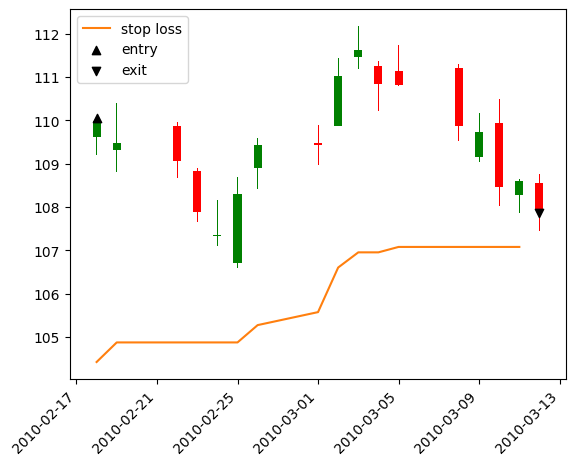

trade 35
entry: [111.3000030517578]
cost_basis: 111.3000030517578
exit: 117.09649658203124
returns: 0.05207990450438619
32


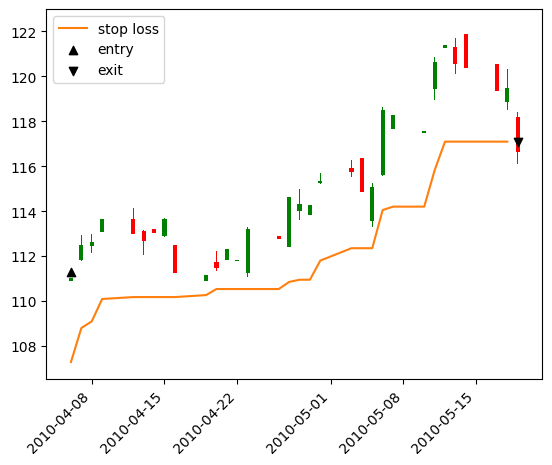

trade 36
entry: [122.23999786376952]
cost_basis: 122.23999786376952
exit: 119.7699966430664
returns: -0.02020616217169609
18


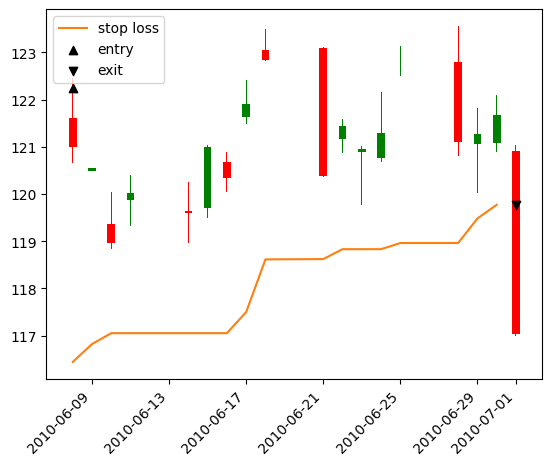

trade 37
entry: [118.6999969482422]
cost_basis: 118.6999969482422
exit: 130.87050514221193
returns: 0.1025316639163566
48


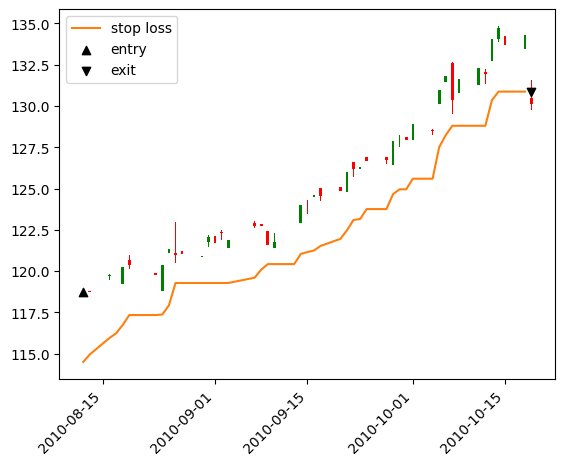

trade 38
entry: [134.85000610351562]
cost_basis: 134.85000610351562
exit: 132.78849334716796
returns: -0.015287450226477392
8


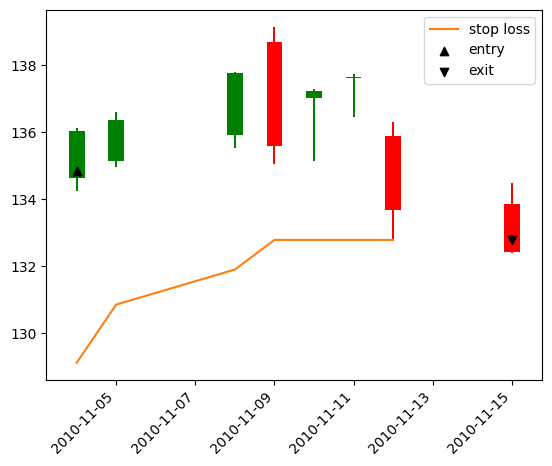

trade 39
entry: [139.14999389648438]
cost_basis: 139.14999389648438
exit: 133.8800048828125
returns: -0.037872721845696185
9


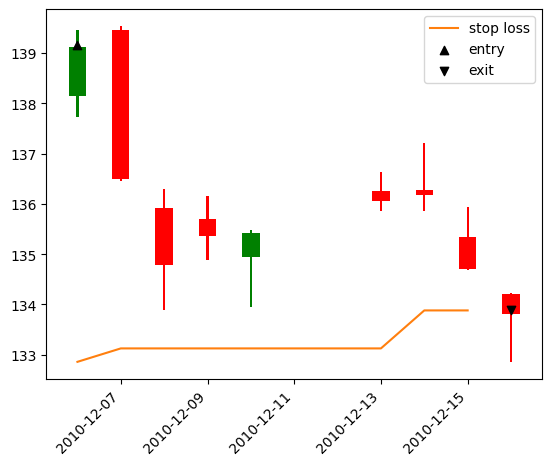

trade 40
entry: [134.39999389648438]
cost_basis: 134.39999389648438
exit: 136.85000610351562
returns: 0.01822925832063849
19


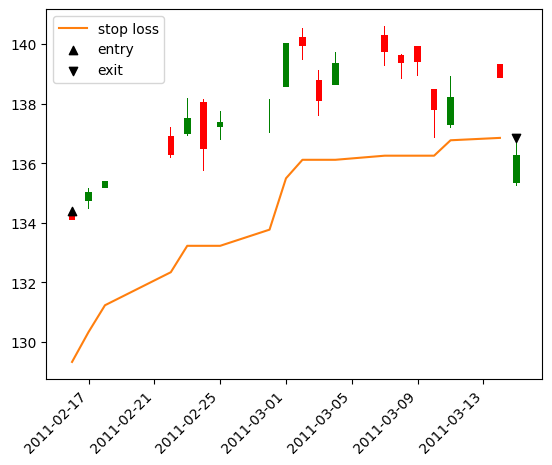

trade 41
entry: [140.61000061035156]
cost_basis: 140.61000061035156
exit: 148.7305030822754
returns: 0.057751955313810055
29


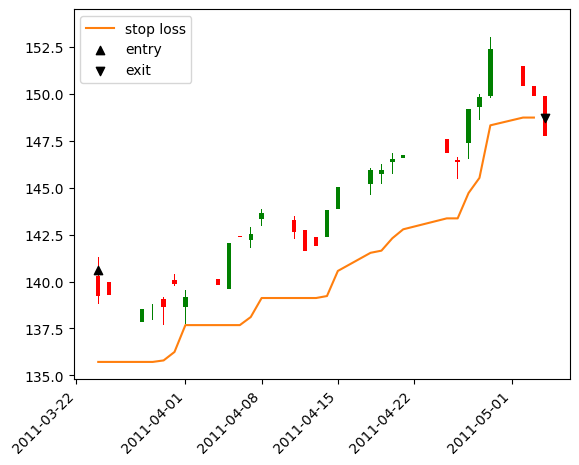

trade 42
entry: [150.97000122070312]
cost_basis: 150.97000122070312
exit: 148.07000732421875
returns: -0.01920907380960322
9


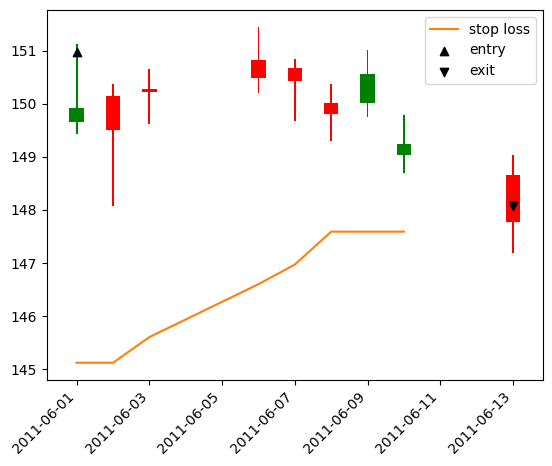

trade 43
entry: [151.4499969482422]
cost_basis: 151.4499969482422
exit: 147.3744972229004
returns: -0.026909869973352204
2


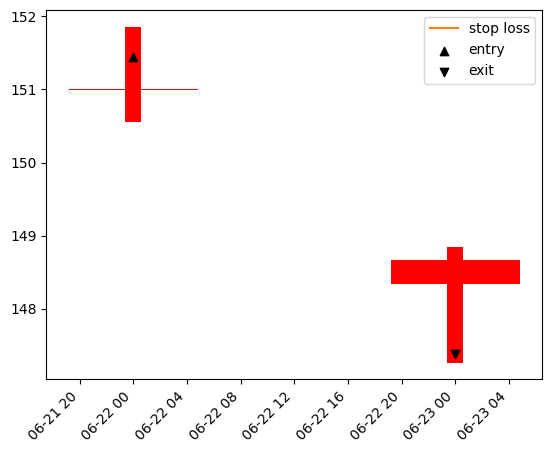

trade 44
entry: [151.86000061035156]
cost_basis: 151.86000061035156
exit: 174.81050567626954
returns: 0.15112936239744462
32


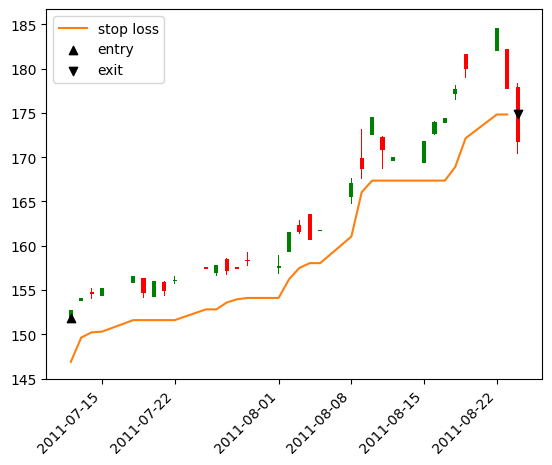

trade 45
entry: [184.82000732421875]
cost_basis: 184.82000732421875
exit: 174.4499969482422
returns: -0.056108700167861535
8


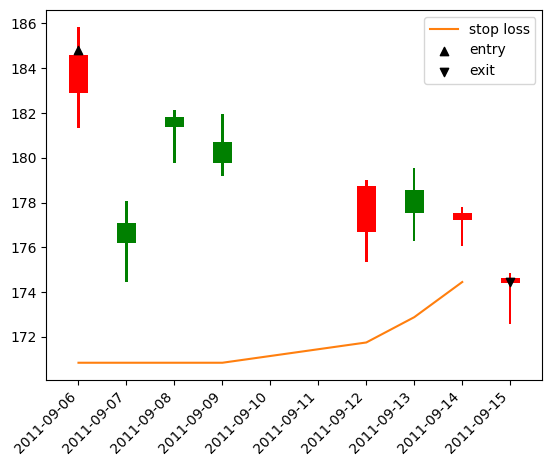

trade 46
entry: [164.16000366210938]
cost_basis: 164.16000366210938
exit: 168.8300018310547
returns: 0.028447843961782387
18


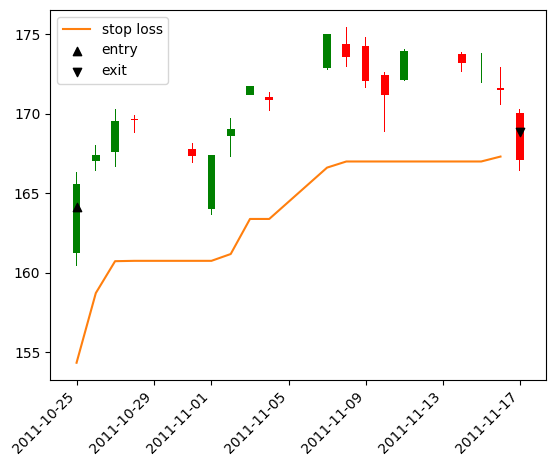

trade 47
entry: [161.6199951171875]
cost_basis: 161.6199951171875
exit: 166.61000061035156
returns: 0.03087492664225059
19


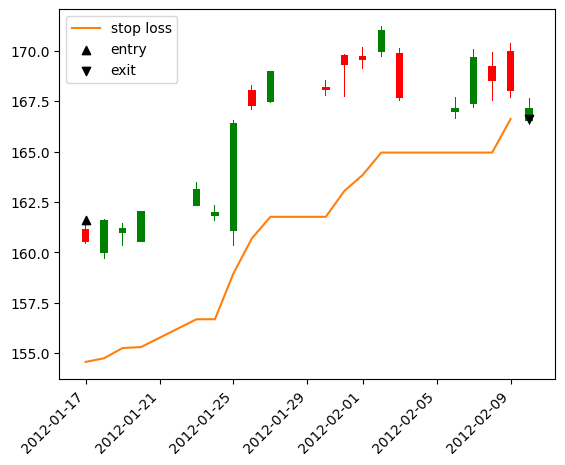

trade 48
entry: [171.22999572753906]
cost_basis: 171.22999572753906
exit: 168.00750045776368
returns: -0.018819689015836975
6


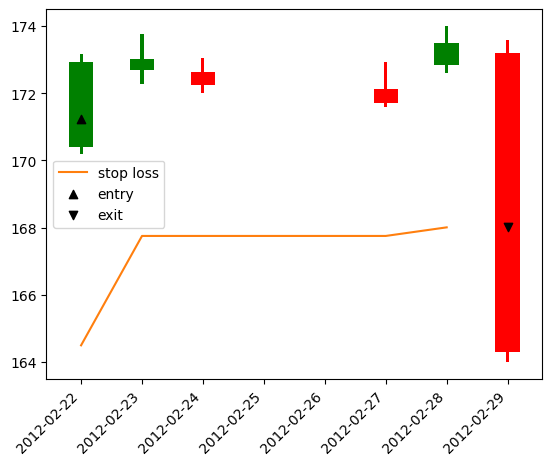

trade 49
entry: [158.30999755859375]
cost_basis: 158.30999755859375
exit: 153.0
returns: -0.03354177020076329
12


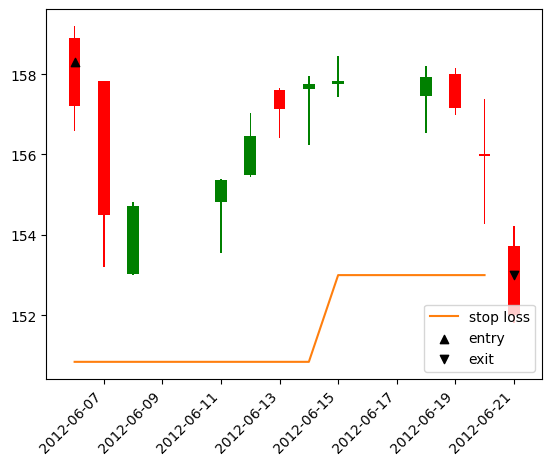

trade 50
entry: [157.72000122070312]
cost_basis: 157.72000122070312
exit: 160.11749343872071
returns: 0.01520093963645546
26


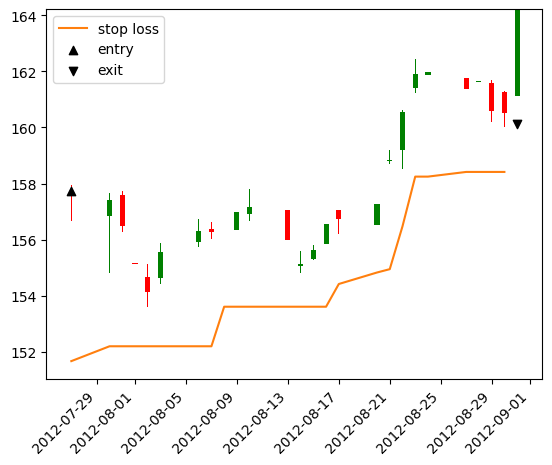

trade 51
entry: [164.22000122070312]
cost_basis: 164.22000122070312
exit: 166.40499954223634
returns: 0.013305311809105947
8


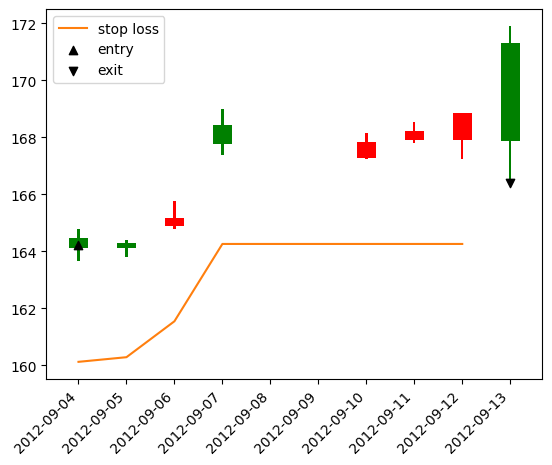

trade 52
entry: [171.91000366210938]
cost_basis: 171.91000366210938
exit: 170.3000030517578
returns: -0.009365368949185953
21


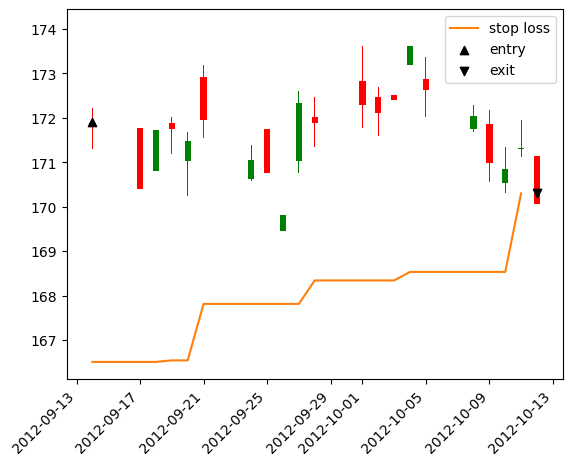

trade 53
entry: [168.5399932861328]
cost_basis: 168.5399932861328
exit: 164.8300018310547
returns: -0.022012528793564256
8


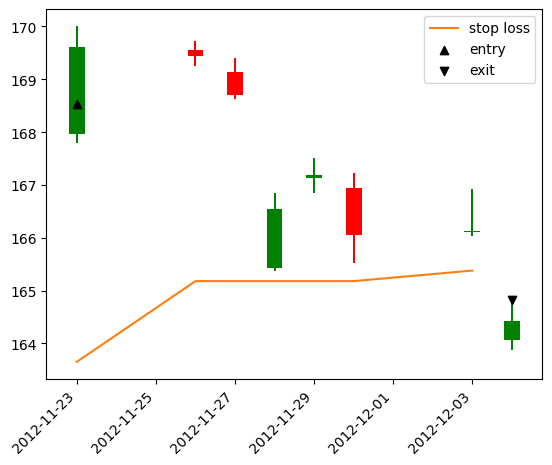

trade 54
entry: [127.58999633789062]
cost_basis: 127.58999633789062
exit: 126.12999725341795
returns: -0.011442896201722768
11


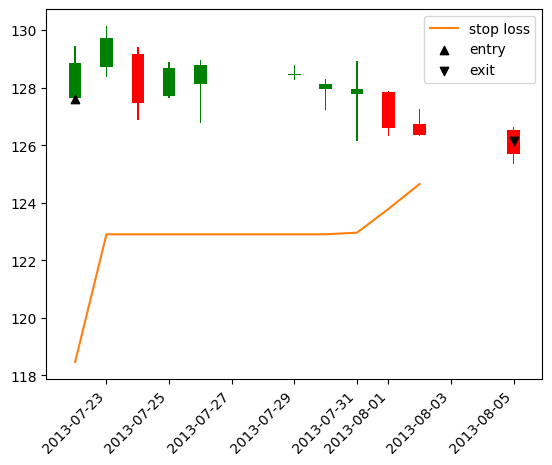

trade 55
entry: [130.13999938964844]
cost_basis: 130.13999938964844
exit: 132.1739990234375
returns: 0.01562931952765046
15


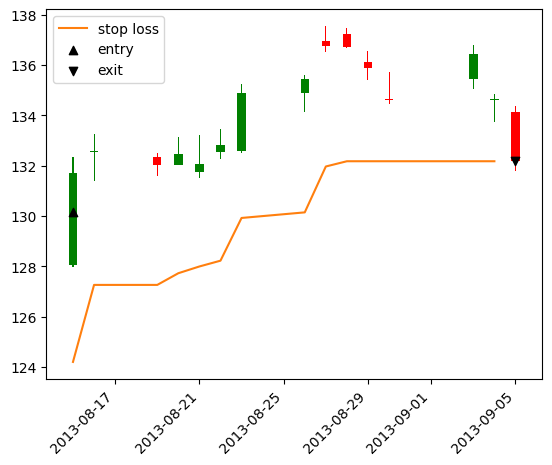

trade 56
entry: [129.5800018310547]
cost_basis: 129.5800018310547
exit: 126.5999984741211
returns: -0.022997401719587078
9


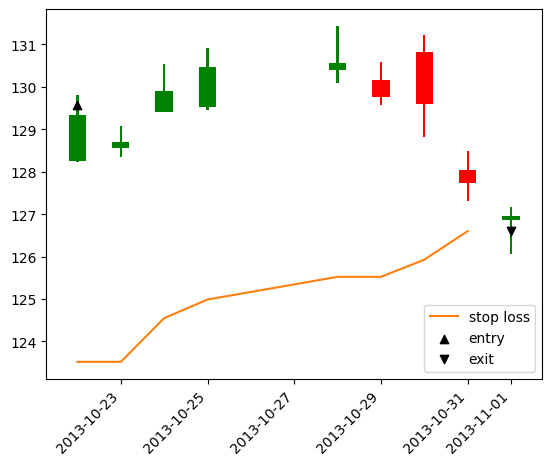

trade 57
entry: [120.7699966430664]
cost_basis: 120.7699966430664
exit: 129.40000610351564
returns: 0.07145822389939342
46


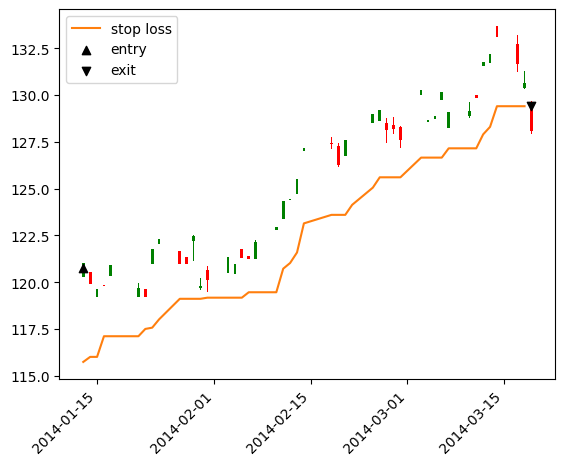

trade 58
entry: [125.23999786376952]
cost_basis: 125.23999786376952
exit: 126.0999984741211
returns: 0.006866820704413035
17


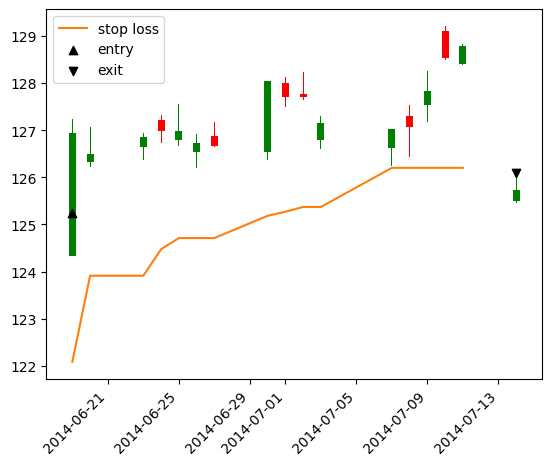

trade 59
entry: [119.23999786376952]
cost_basis: 119.23999786376952
exit: 117.87999725341795
returns: -0.011405573924157138
11


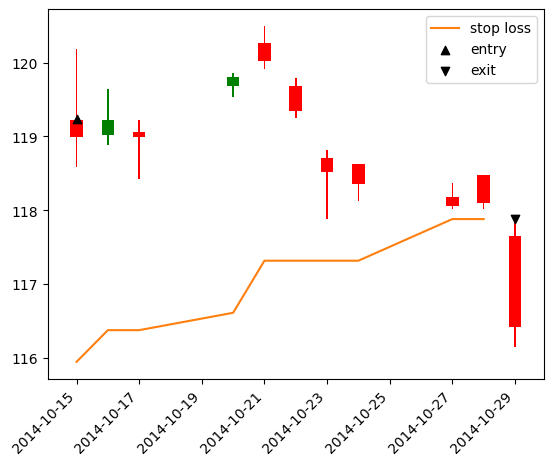

trade 60
entry: [115.95999908447266]
cost_basis: 115.95999908447266
exit: 114.23999786376952
returns: -0.014832711575395759
12


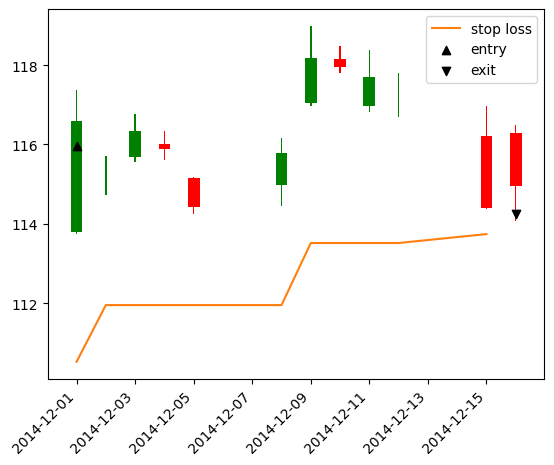

trade 61
entry: [118.37999725341795]
cost_basis: 118.37999725341795
exit: 120.41550407409666
returns: 0.017194685486613615
13


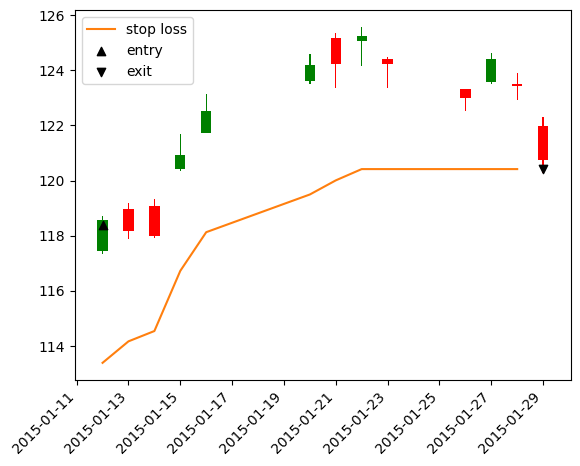

trade 62
entry: [116.5199966430664]
cost_basis: 116.5199966430664
exit: 114.38999938964844
returns: -0.01828010053881782
11


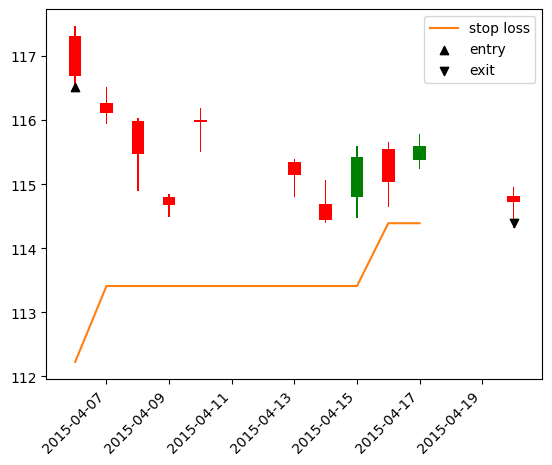

trade 63
entry: [116.62000274658205]
cost_basis: 116.62000274658205
exit: 113.8029960632324
returns: -0.024155433176168473
9


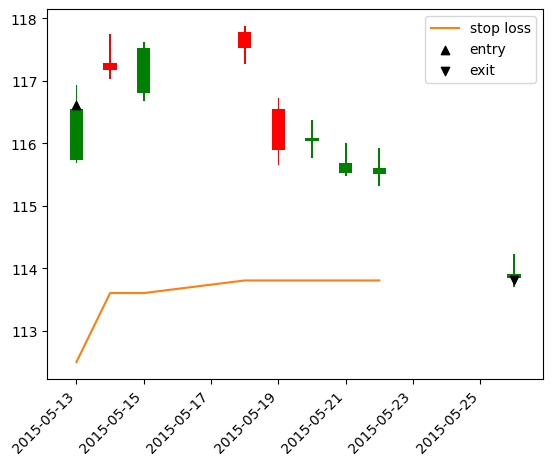

trade 64
entry: [107.91000366210938]
cost_basis: 107.91000366210938
exit: 108.05999755859376
returns: 0.0013899906532674582
6


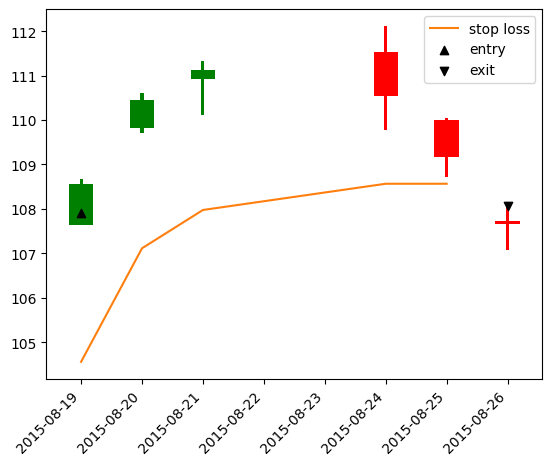

trade 65
entry: [109.7699966430664]
cost_basis: 109.7699966430664
exit: 106.67300262451172
returns: -0.028213483768474747
5


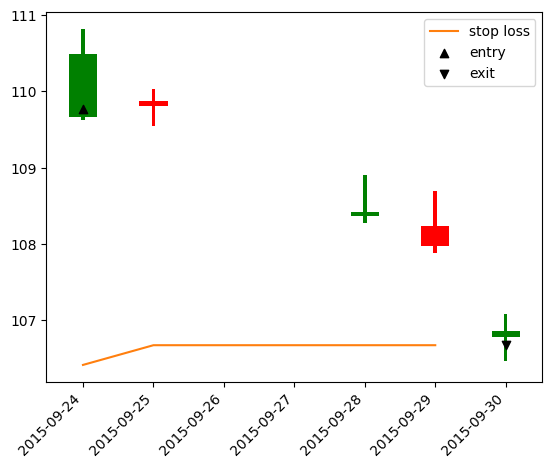

trade 66
entry: [110.81999969482422]
cost_basis: 110.81999969482422
exit: 110.95999908447266
returns: 0.0012633043677492096
14


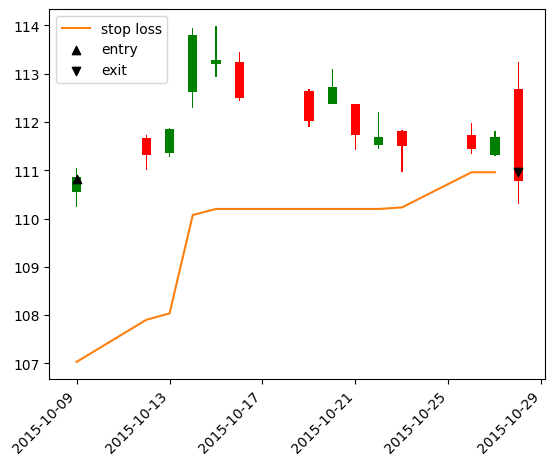

trade 67
entry: [103.93000030517578]
cost_basis: 103.93000030517578
exit: 102.71049575805664
returns: -0.01173390304568691
7


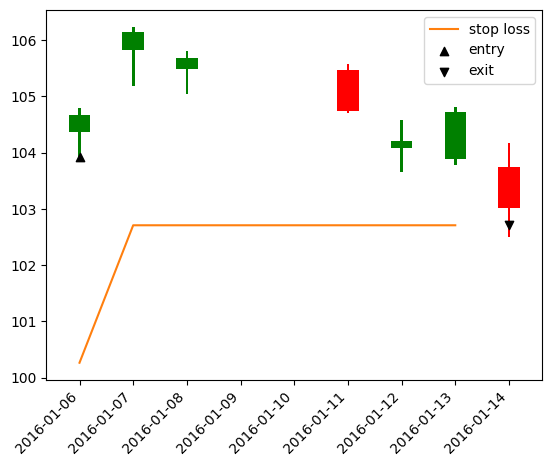

trade 68
entry: [106.26000213623048]
cost_basis: 106.26000213623048
exit: 115.72949867248535
returns: 0.08911628407568176
15


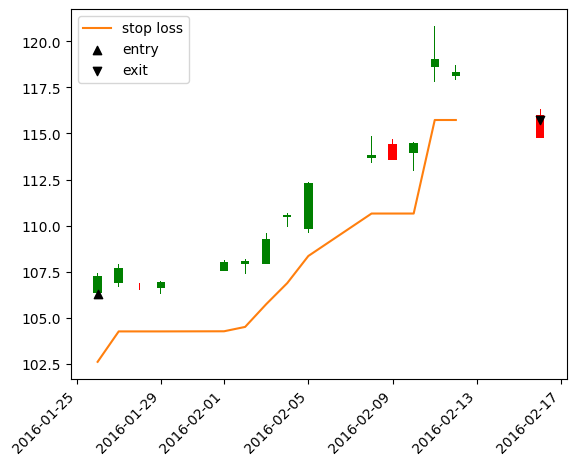

trade 69
entry: [120.83999633789062]
cost_basis: 120.83999633789062
exit: 117.36000061035156
returns: -0.028798376638545745
10


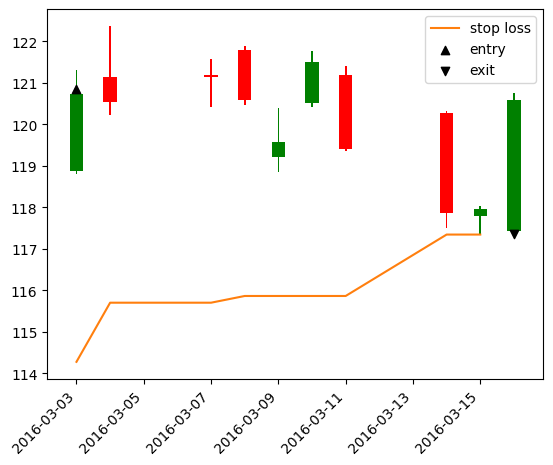

trade 70
entry: [120.3499984741211]
cost_basis: 120.3499984741211
exit: 120.08000183105467
returns: -0.0022434287203125965
20


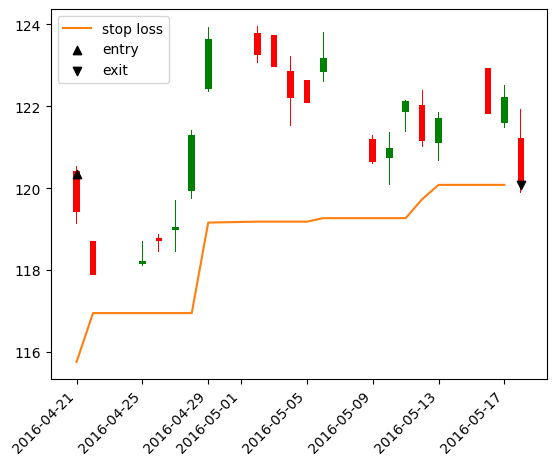

trade 71
entry: [122.97000122070312]
cost_basis: 122.97000122070312
exit: 121.74899826049806
returns: -0.009929275010851203
6


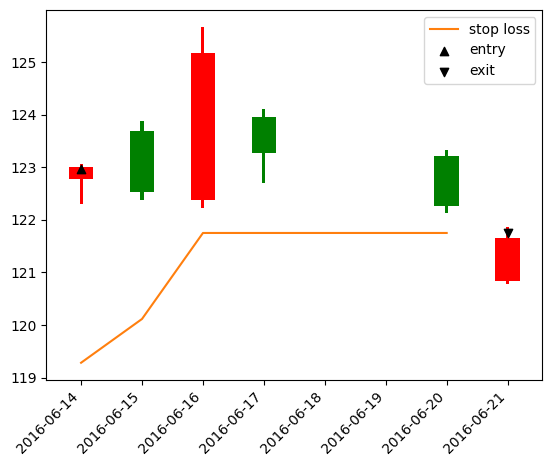

trade 72
entry: [125.66999816894533]
cost_basis: 125.66999816894533
exit: 126.02999877929688
returns: 0.0028646503986383366
18


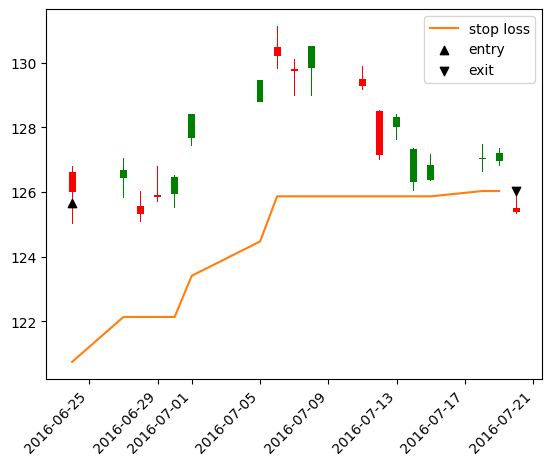

trade 73
entry: [123.18000030517578]
cost_basis: 123.18000030517578
exit: 121.77250022888182
returns: -0.011426368507930718
6


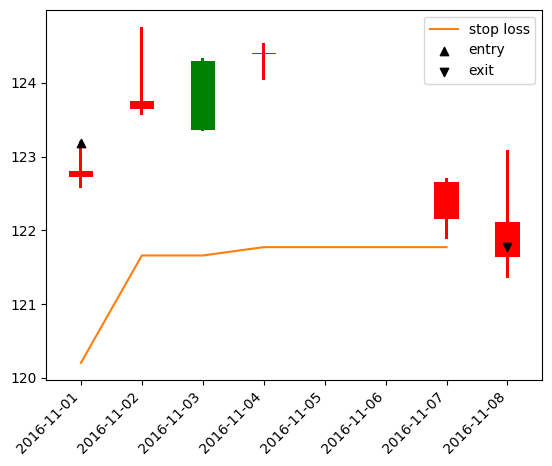

trade 74
entry: [112.5]
cost_basis: 112.5
exit: 112.83000183105467
returns: 0.0029333496093748735
16


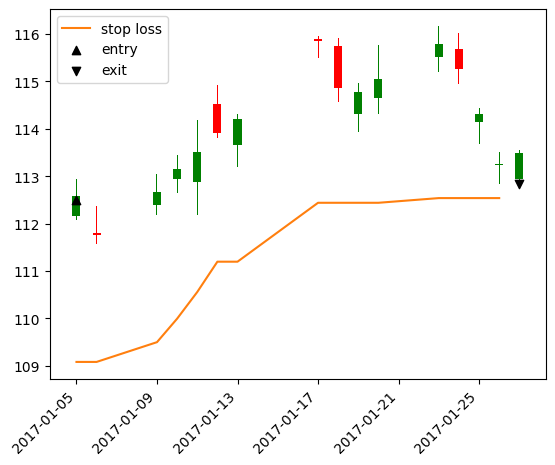

trade 75
entry: [116.16999816894533]
cost_basis: 116.16999816894533
exit: 116.95449905395509
returns: 0.00675304207088708
21


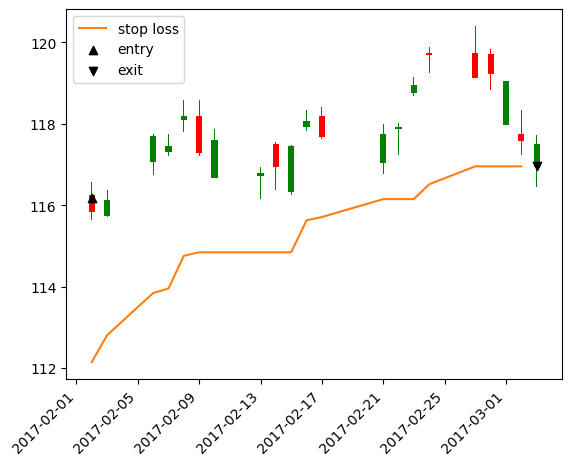

trade 76
entry: [120.08000183105467]
cost_basis: 120.08000183105467
exit: 120.27099685668946
returns: 0.0015905648128112931
12


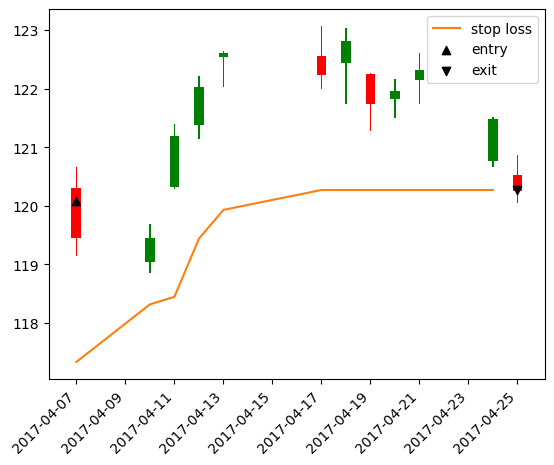

trade 77
entry: [120.7699966430664]
cost_basis: 120.7699966430664
exit: 120.46749801635745
returns: -0.0025047498146661584
10


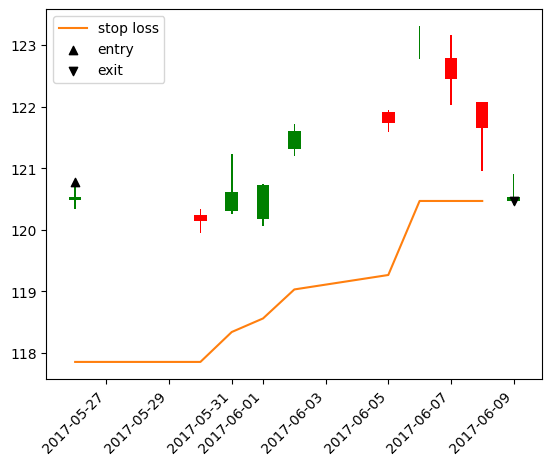

trade 78
entry: [119.58000183105467]
cost_basis: 119.58000183105467
exit: 124.76000213623048
returns: 0.04331828253769582
38


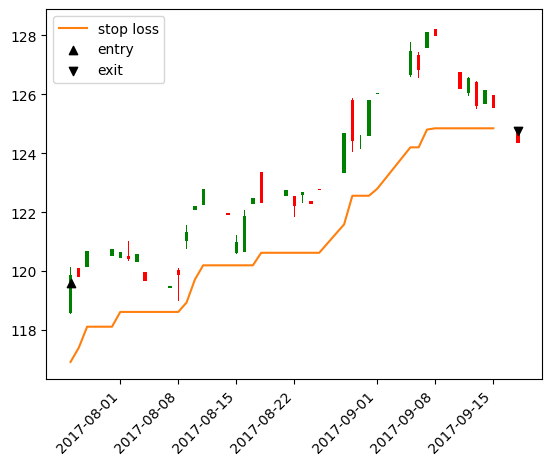

trade 79
entry: [122.41000366210938]
cost_basis: 122.41000366210938
exit: 121.04000091552734
returns: -0.011191918189657729
9


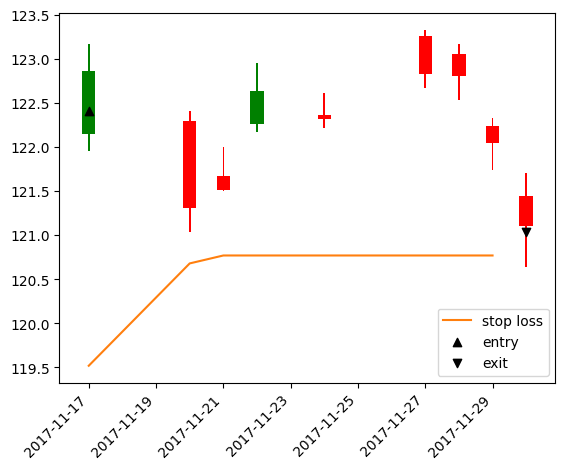

trade 80
entry: [122.55999755859376]
cost_basis: 122.55999755859376
exit: 126.42599830627441
returns: 0.03154374041034374
23


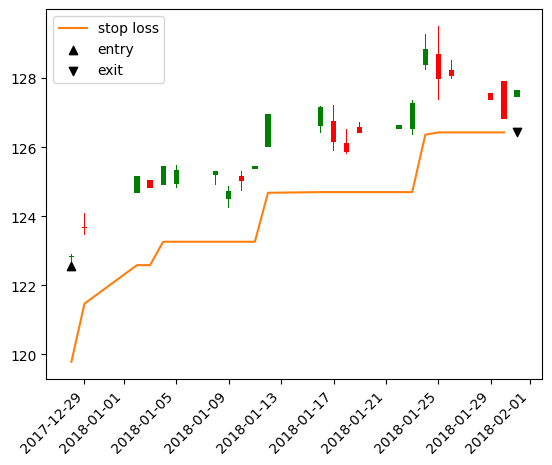

trade 81
entry: [127.61000061035156]
cost_basis: 127.61000061035156
exit: 125.76000213623048
returns: -0.014497284423420102
21


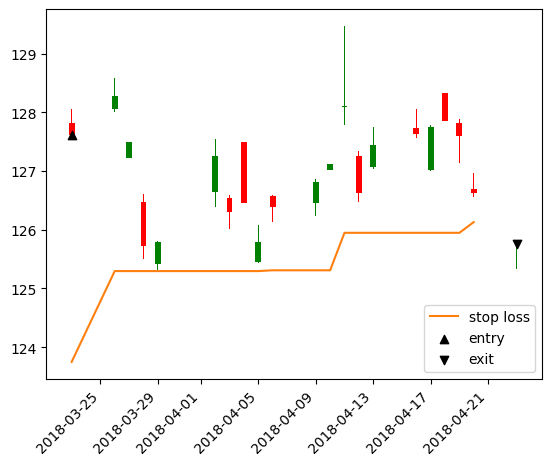

trade 82
entry: [123.81999969482422]
cost_basis: 123.81999969482422
exit: 122.1999969482422
returns: -0.013083530532828248
2


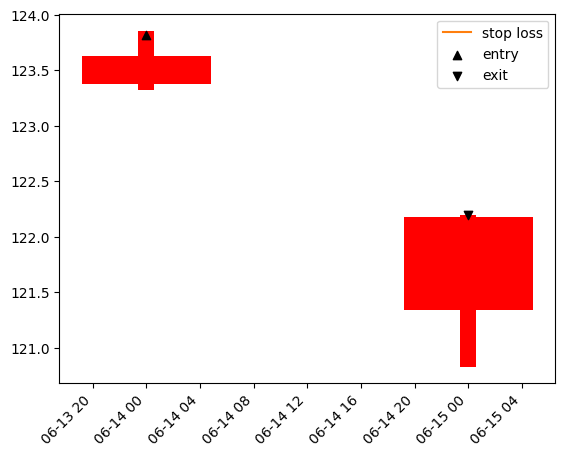

trade 83
entry: [114.77999877929688]
cost_basis: 114.77999877929688
exit: 115.16999816894533
returns: 0.003397799214115315
15


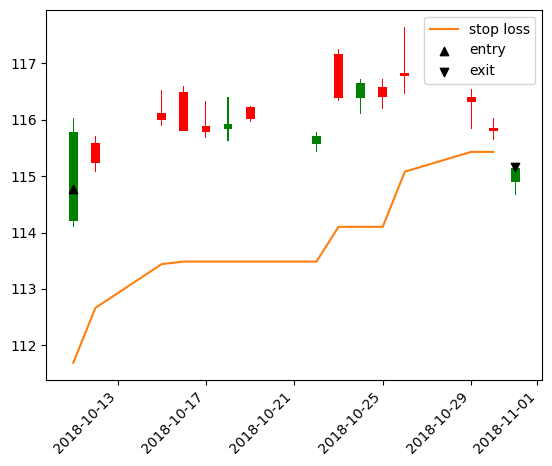

trade 84
entry: [116.93000030517578]
cost_basis: 116.93000030517578
exit: 121.0199966430664
returns: 0.034978160670624626
32


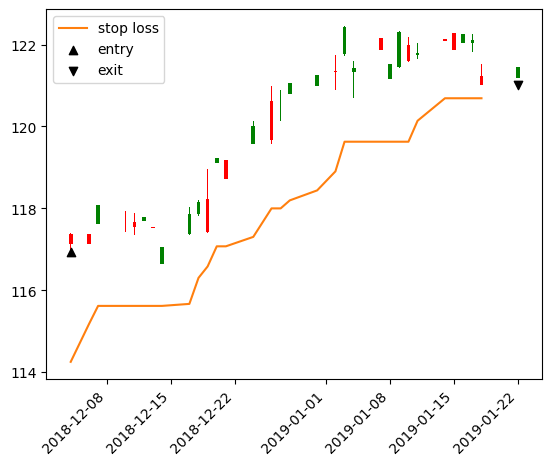

trade 85
entry: [122.45999908447266]
cost_basis: 122.45999908447266
exit: 124.60749816894533
returns: 0.01753633105118129
23


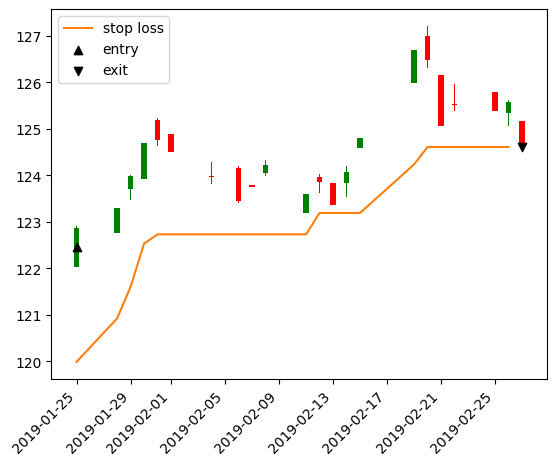

trade 86
entry: [122.33000183105467]
cost_basis: 122.33000183105466
exit: 120.5904945373535
returns: -0.014219792918040824
5


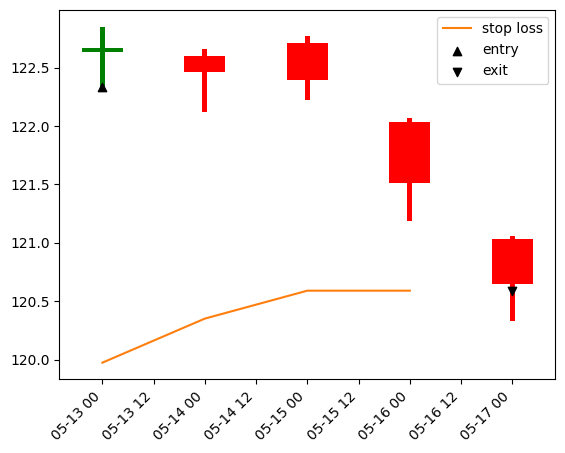

trade 87
entry: [122.8499984741211]
cost_basis: 122.8499984741211
exit: 131.46700744628905
returns: 0.07014252404718721
22


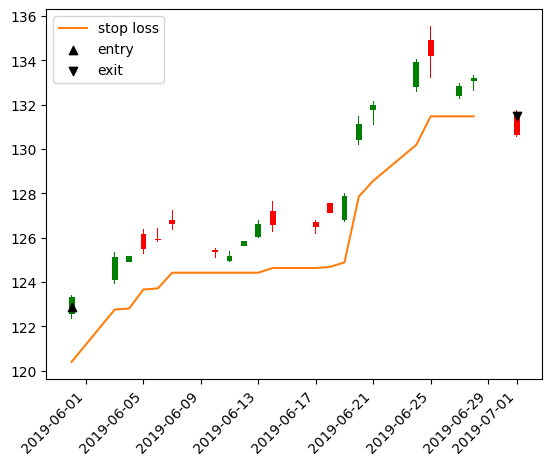

trade 88
entry: [135.5500030517578]
cost_basis: 135.5500030517578
exit: 133.02000427246094
returns: -0.018664689947154273
11


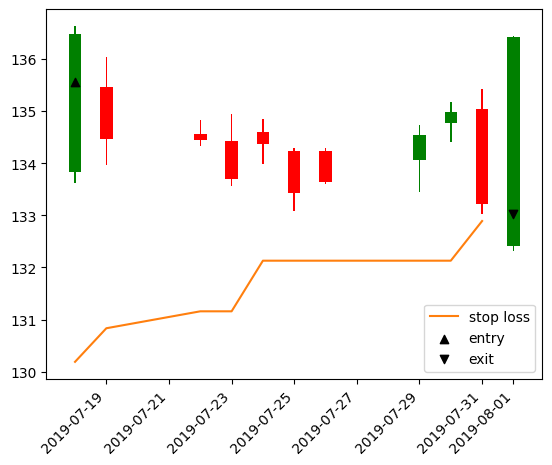

trade 89
entry: [137.0500030517578]
cost_basis: 137.0500030517578
exit: 141.63999938964844
returns: 0.033491399019941526
25


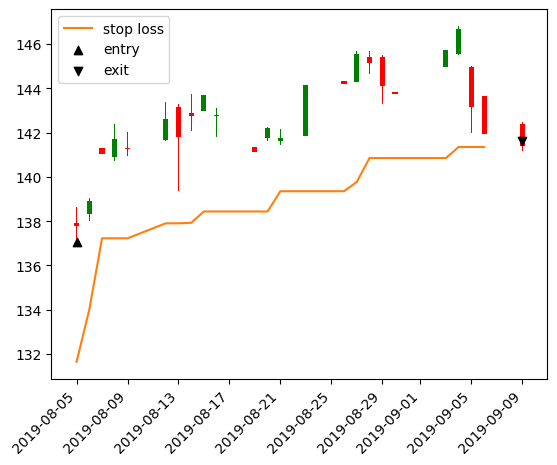

trade 90
entry: [142.8300018310547]
cost_basis: 142.8300018310547
exit: 139.5500030517578
returns: -0.022964354388068937
3


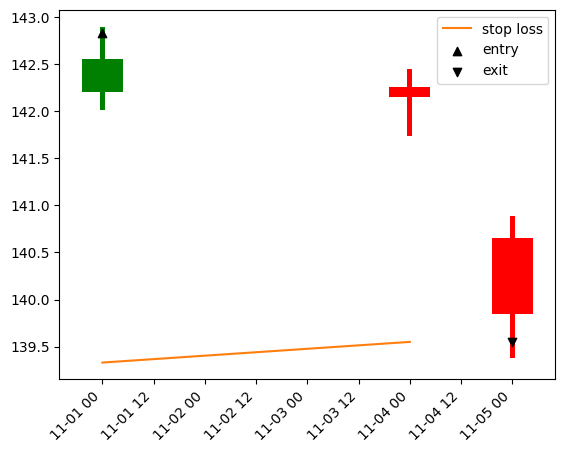

trade 91
entry: [139.57000732421875]
cost_basis: 139.57000732421875
exit: 145.29098739624024
returns: 0.040990039204710726
22


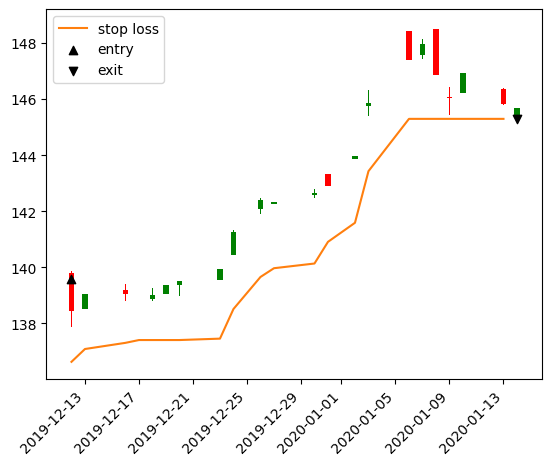

trade 92
entry: [148.61000061035156]
cost_basis: 148.61000061035156
exit: 145.86248855590821
returns: -0.018488069733928577
7


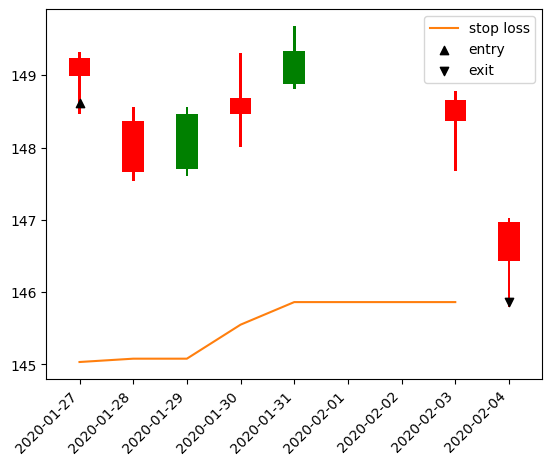

trade 93
entry: [149.67999267578125]
cost_basis: 149.67999267578125
exit: 154.32849502563477
returns: 0.031056270559302743
6


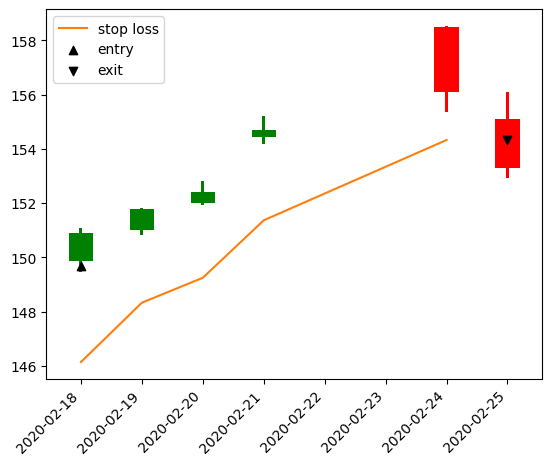

trade 94
entry: [158.52999877929688]
cost_basis: 158.52999877929688
exit: 151.5500030517578
returns: -0.0440294946148111
5


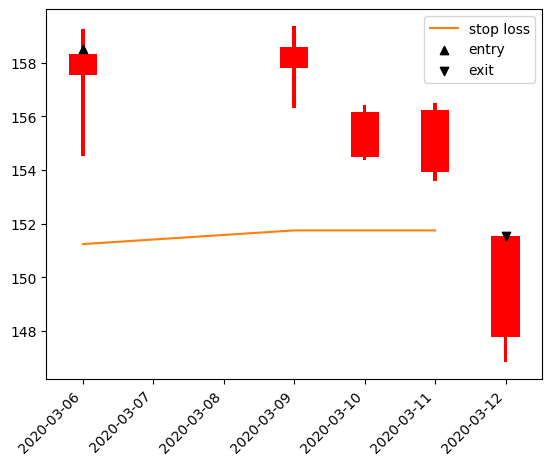

trade 95
entry: [157.22000122070312]
cost_basis: 157.22000122070312
exit: 159.72000122070312
returns: 0.01590128470035143
33


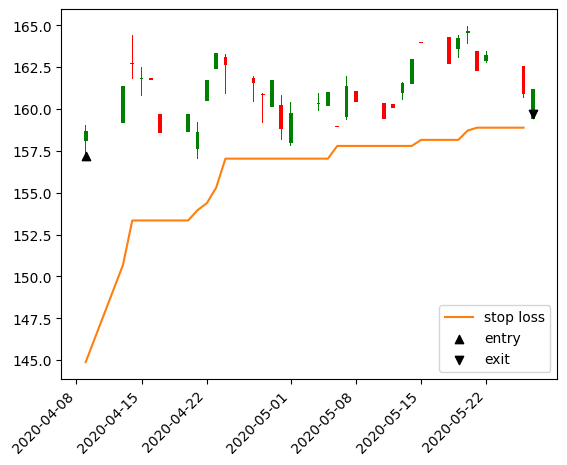

trade 96
entry: [164.0800018310547]
cost_basis: 164.0800018310547
exit: 183.97999572753903
returns: 0.1212822627645654
37


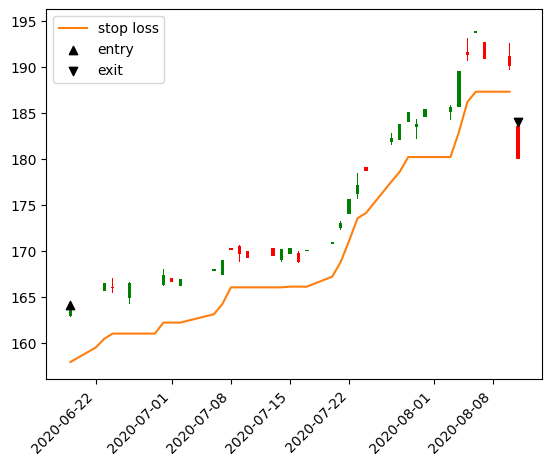

trade 97
entry: [181.1699981689453]
cost_basis: 181.1699981689453
exit: 176.85000610351562
returns: -0.02384496389629144
6


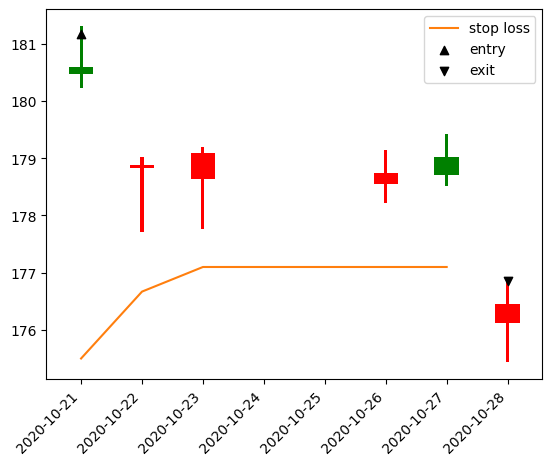

trade 98
entry: [181.30999755859372]
cost_basis: 181.30999755859372
exit: 176.4499969482422
returns: -0.0268049234779838
3


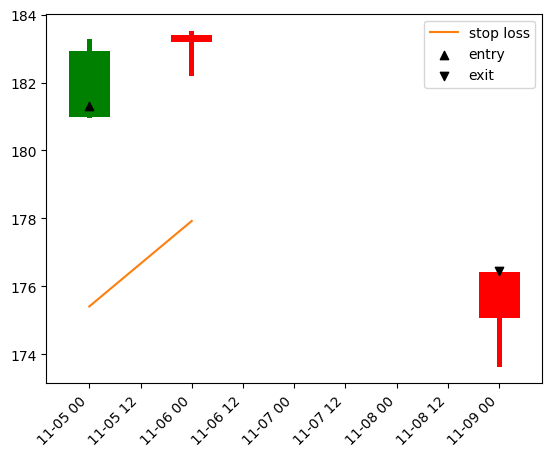

trade 99
entry: [176.86000061035156]
cost_basis: 176.86000061035156
exit: 176.99000549316406
returns: 0.0007350722739107061
15


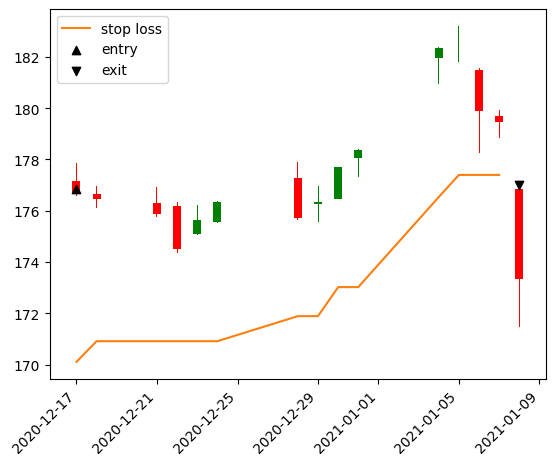

trade 100
entry: [164.14999389648438]
cost_basis: 164.14999389648438
exit: 174.66000366210938
returns: 0.06402686662451405
47


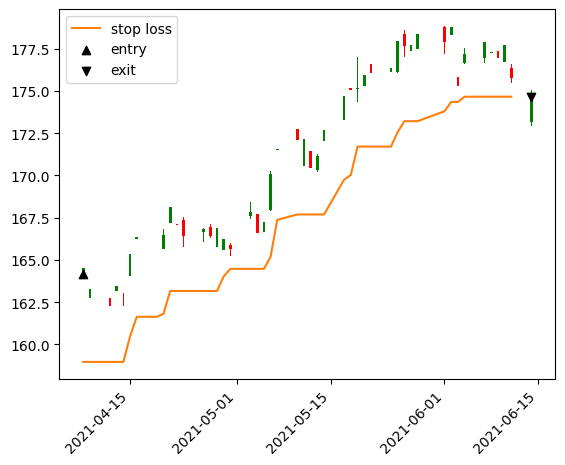

trade 101
entry: [171.3000030517578]
cost_basis: 171.3000030517578
exit: 165.92999267578125
returns: -0.03134857139701293
7


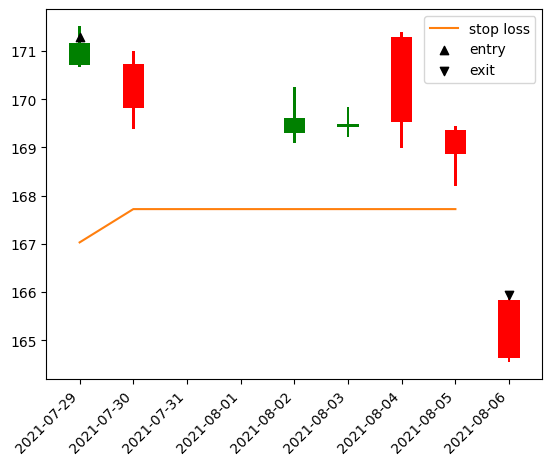

trade 102
entry: [170.19000244140625]
cost_basis: 170.19000244140625
exit: 166.74000549316406
returns: -0.02027144308567695
3


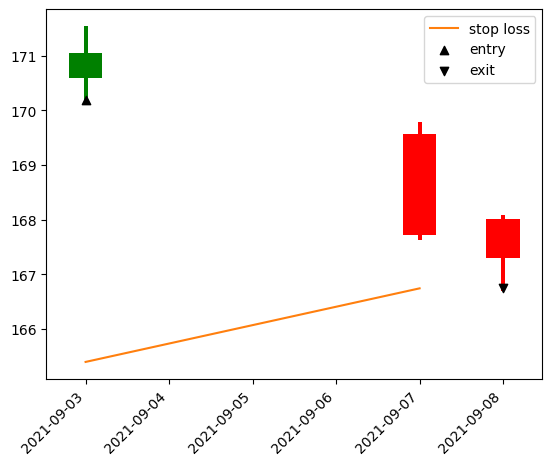

trade 103
entry: [167.9199981689453]
cost_basis: 167.9199981689453
exit: 165.63999938964844
returns: -0.013577887113856175
15


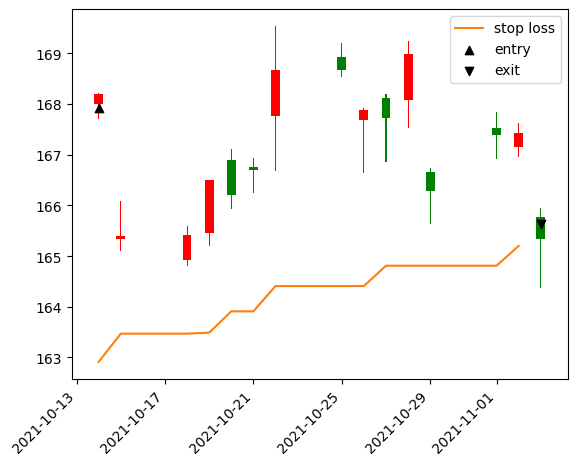

trade 104
entry: [169.5399932861328]
cost_basis: 169.5399932861328
exit: 170.05999755859375
returns: 0.0030671481246511896
12


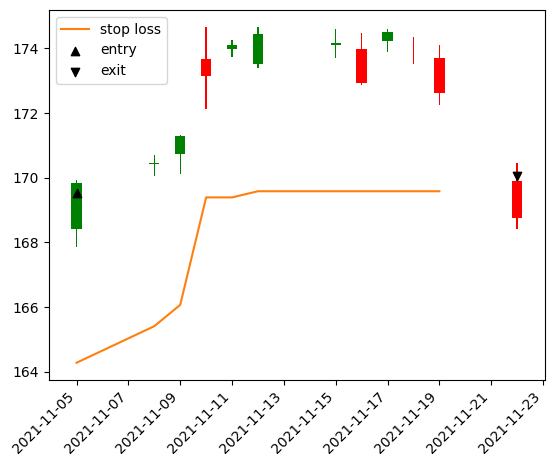

trade 105
entry: [169.1300048828125]
cost_basis: 169.1300048828125
exit: 167.18799438476563
returns: -0.011482353467632534
10


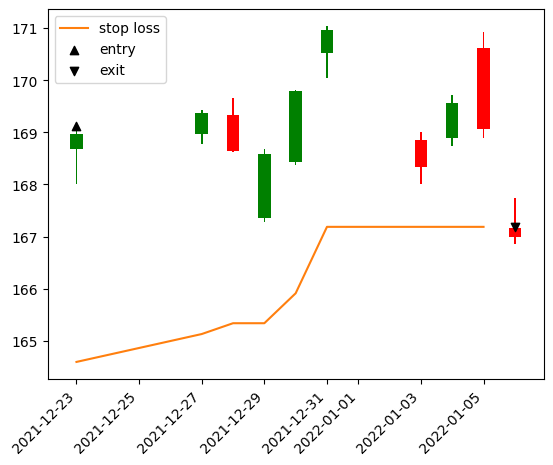

trade 106
entry: [171.0399932861328]
cost_basis: 171.0399932861328
exit: 169.08999633789062
returns: -0.01140082451348111
7


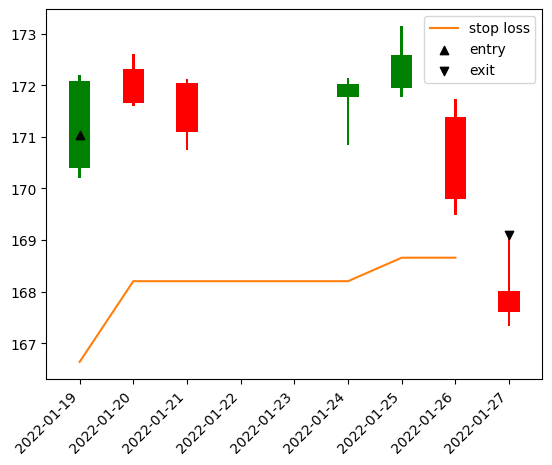

trade 107
entry: [173.14999389648438]
cost_basis: 173.14999389648438
exit: 177.1445045471191
returns: 0.023069655162811075
9


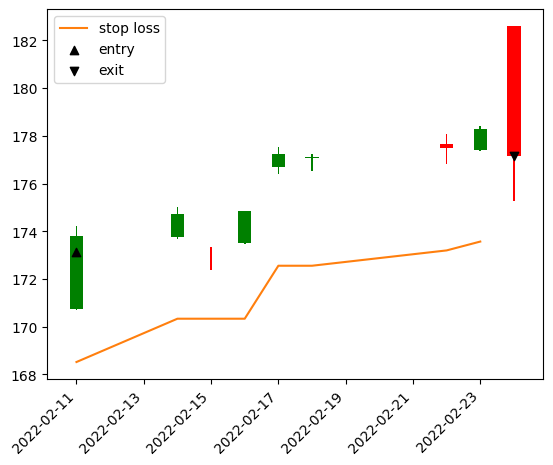

trade 108
entry: [182.6000061035156]
cost_basis: 182.6000061035156
exit: 185.767000579834
returns: 0.017343890309198733
4


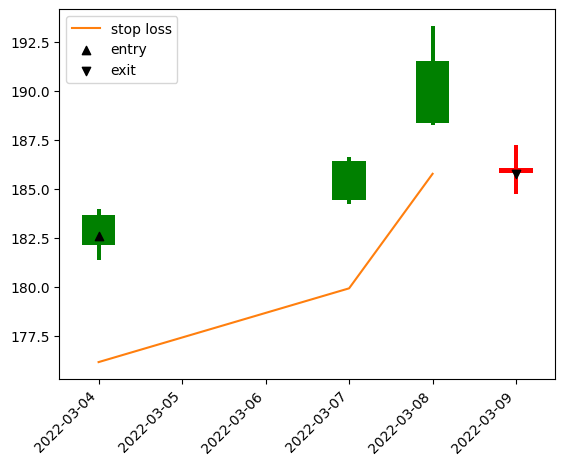

trade 109
entry: [183.50999450683597]
cost_basis: 183.50999450683597
exit: 180.23800582885738
returns: -0.017830029839909882
8


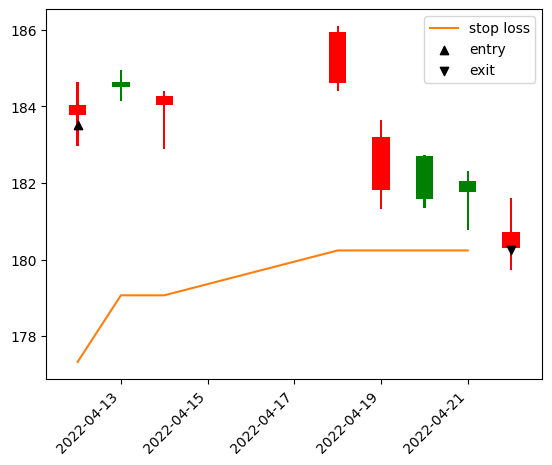

trade 110
entry: [174.4499969482422]
cost_basis: 174.4499969482422
exit: 170.4600067138672
returns: -0.022871827481652496
2


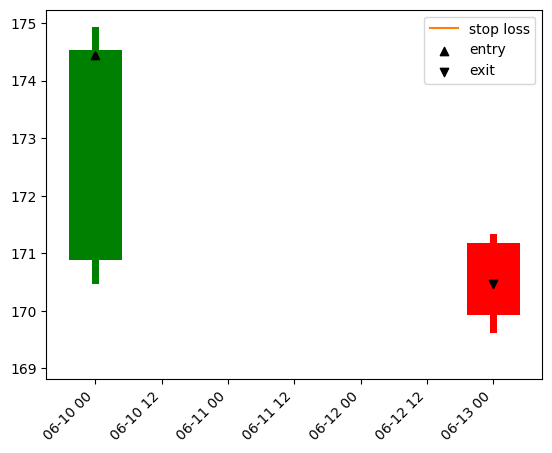

trade 111
entry: [166.4600067138672]
cost_basis: 166.4600067138672
exit: 163.9499969482422
returns: -0.01507875564332715
11


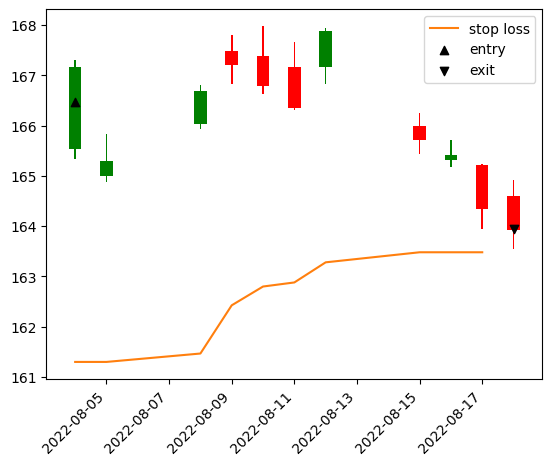

trade 112
entry: [156.80999755859375]
cost_basis: 156.80999755859375
exit: 177.77999877929688
returns: 0.1337287261474987
59


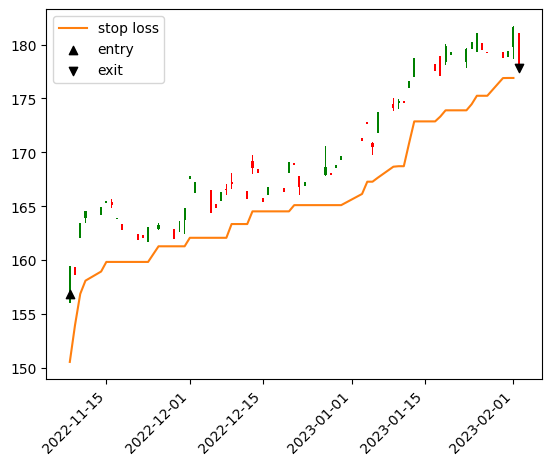

trade 113
entry: [176.3000030517578]
cost_basis: 176.3000030517578
exit: 184.1000061035156
returns: 0.044242784553258765
29


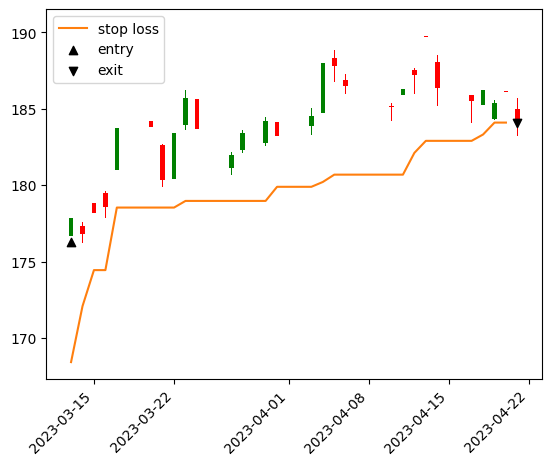

trade 114
entry: [190.41000366210935]
cost_basis: 190.41000366210935
exit: 184.5200042724609
returns: -0.03093324550374198
9


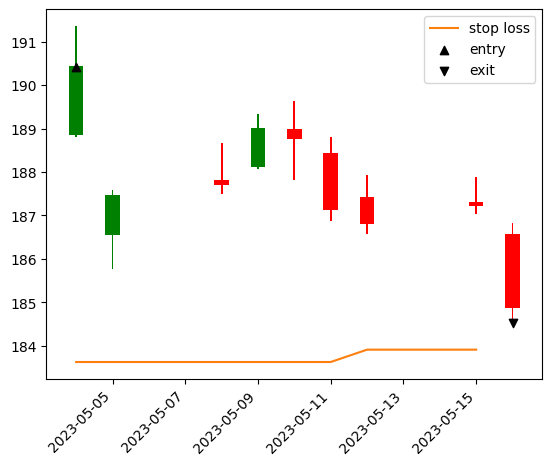

In [28]:
tl.plot_all_trades()

We can plot the trades that occur over a specific period of time to see how this strategy perform.

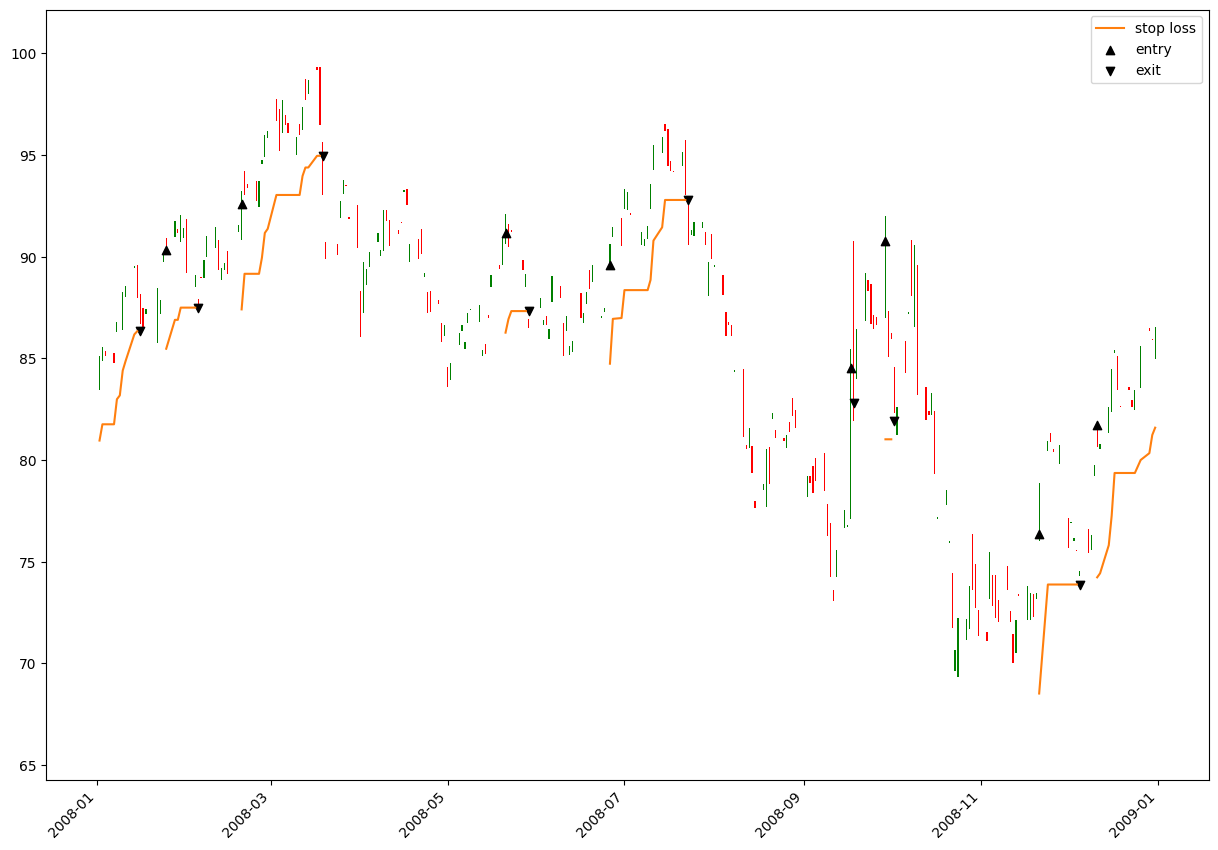

In [29]:

start_datetime= pd.to_datetime(dt.date(2008, 1, 1))
end_datetime = pd.to_datetime(dt.date(2009, 1, 1))

tl.plot_time_period(df, start_datetime, end_datetime)

We note that the time in trade for winning trades is generally higher than that of losing trades.

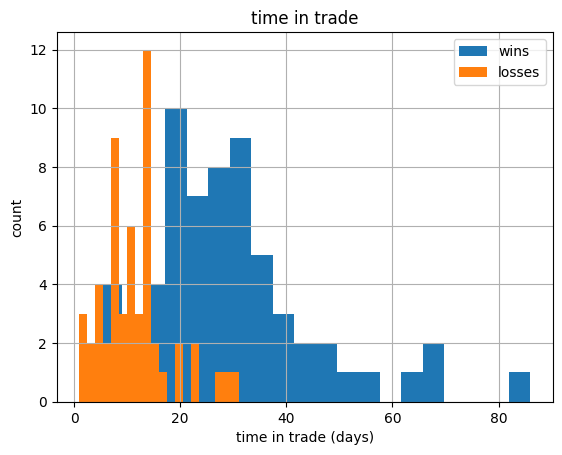

In [37]:
tl.win_records['time_in_trade'].hist(bins=20, label='wins')
tl.loss_records['time_in_trade'].hist(bins=20, label='losses')
plt.xlabel('time in trade (days)')
plt.ylabel('count')
plt.title('time in trade')
plt.legend()
plt.show()

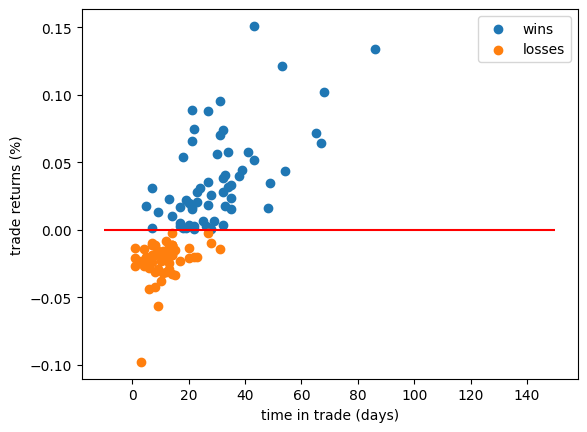

In [38]:
plt.scatter(tl.win_records['time_in_trade'], tl.win_records['returns'], label='wins')
plt.scatter(tl.loss_records['time_in_trade'], tl.loss_records['returns'], label='losses')
plt.hlines(0, -10, 150, color='red')
plt.legend()
plt.xlabel('time in trade (days)')
plt.ylabel('trade returns (%)')
plt.show()

### Analysis

We note that the turtle trading rules follow a trend-following or momentum trading strategy. The characteristic of these strategies is greater volatility, with lower win-rate but higher returns per winning trade.

Ideally, the strategy goes long when a long-term upward trend is established and follows the trend until it is exhausted, while avoiding big drawdowns when long-term downward trends are established. 

The downside to this strategy is that short-term volatility is likely to cause whipsaw losses. An example of this is losses when the underlying is trading within a range.

Therefore, the way to optimise this strategy is to pick the underlying to more frequent long-term trends with greater magnitude compared to short-term volatility. It does not matter which direction that long-term trend is in since we can just inverse the rules, e.g. go short when price breaks out under the 20-day low. This is also possibly why the original turtle traders focused on commodity trading, since commodities tend to exhibit trends based on the physical demand and supply of the commodity, whereas equities may be more volatile in the short-term due to speculation.

Another key part to the success of this strategy is to trade diversified and uncorrelated assets so that the various assets will be trending at different times. This will go a long way towards reducing the volatility of a portfolio trading all of these assets.

Another idea is to trade this strategy on leveraged ETFs, for example UPRO (3 x leveraged SP500) instead of trading on SPY. The nature of the ETF (3 x daily returns) is likely to cause the magnitude of long-term trends to increase significantly, thus increasing the returns per winning trade of this strategy. The volatility drag of the leverage should also reduce the number of whipsaw losing trades. Therefore, the overall profitability of this strategy on leveraged ETFs should increase. More testing is required however, since we have to account for a higher expense ratio, tracking error, and a lack of historical data since these ETFs are a relatively recent invention.